In [1]:
from utils import *

In [2]:
path = 'activatable promoters/txtl/'
file = '211129_pDA30x_titrations_TIDY.csv'
layout = '211129_pDA30x_titrations_LAYOUT.csv'
plate = pd.read_csv(path+layout, index_col = 0, dtype = str) # reads plate layout

labels = pd.unique(np.concatenate(plate.values))[1:]
tidy = pd.read_csv(path+file,index_col=0)

conc = [30,10,2,0.4,0.08,0.016,0]

kinetics = get_kinetics(tidy, labels, 'RFPEx')

In [3]:
def subtract(m1, s1, m2, s2):
    m = m1-m2
    s = (s1**2 + s2**2)**0.5
    return pd.DataFrame({'m':m, 's':s})

def divide(m1, s1, m2, s2):
    m = m1/m2
    s = m*((s1/m1)**2 + (s2/m2)**2)**0.5
    return pd.DataFrame({'m':m, 's':s})

In [33]:
var = ['300','302','303','blank']
bsub = {l:subtract(kinetics[l].mean(1), kinetics[l].std(1), kinetics['blank'].mean(1), kinetics['blank'].std(1)) for l in labels}
[bs300,bs302, bs303] = [{k[-1]:v for k,v in bsub.items() if l in k} for l in var[:-1]]


In [34]:
[fa300, fa302, fa303] = [{k:divide(v.m, v.s, bs['7'].m, bs['7'].s) for k,v in bs.items()} for bs in [bs300, bs302, bs303]]

(0.00031622776601683794, 31.622776601683793)

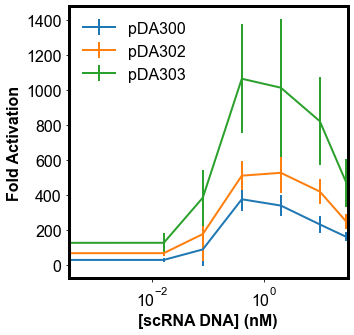

In [35]:
plt.figure(figsize=(5,5))
t = 90
plt.errorbar(conc, [fa.iloc[t].m for fa in fa300.values()], [fa.iloc[t].s for fa in fa300.values()], label = 'pDA300')
plt.errorbar(conc, [fa.iloc[t].m for fa in fa302.values()], [fa.iloc[t].s for fa in fa302.values()], label = 'pDA302')
plt.errorbar(conc, [fa.iloc[t].m for fa in fa303.values()], [fa.iloc[t].s for fa in fa303.values()], label = 'pDA303')

plt.xscale('log')
plt.xlabel('[scRNA DNA] (nM)')
plt.ylabel('Fold Activation')
plt.legend(frameon=False)
plt.xlim(([10**(-3.5), 10**(1.5)]))

Text(0.5, 0, 'promoter variant')

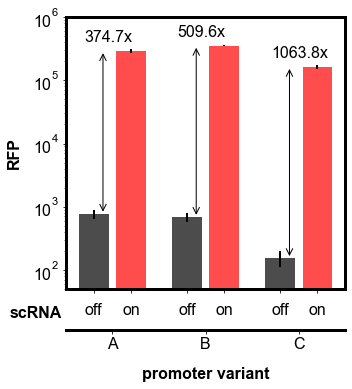

In [36]:
plt.figure(figsize=(5,5))

X = [0.5,3,5.5]

for b,x in zip([bs300,bs302,bs303],X):
    vals = np.array([r.iloc[t].m for r in b.values()])[[6,3]]
    vals_err = np.array([r.iloc[t].s for r in b.values()])[[6,3]]
    plt.bar([x-0.5,x+0.5], vals, yerr = vals_err, color = ['k','r'], alpha = 0.7)
    
    plt.text(x-0.75,vals[1]*1.4,'{x:.{d}f}x'.format(x=vals[1]/vals[0], d =1))
    plt.annotate("", xy=(x-0.25, vals[0]), xytext=(x-0.25, vals[1]),arrowprops=dict(arrowstyle="<->"))

plt.yscale('log')
plt.ylabel('RFP', labelpad = 1.1*ypad)
plt.ylim([50, 10e5])

ax1 = plt.gca()
ax1.set_xlabel('scRNA')
ax1.tick_params(axis='x', which='major', pad=10)
ax1.xaxis.set_label_coords(-0.11, -0.06)
ax1.set_xticks(sum([[x-0.5,x+0.5] for x in X],[]))
ax1.set_xticklabels(labels = ['off','on']*3, size = 16)

ax2 = ax1.twiny(); ax2.set_xlim(ax1.get_xlim())
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
ax2.spines["bottom"].set_position(("axes", -0.15))

ax2.set_xticks(X)
ax2.set_xticklabels(['A','B','C'])
ax2.set_xlabel('promoter variant', labelpad = xpad)



In [37]:
import lmfit as lmf

x = sum([[c,c,c] for c in conc],[])
y = sum([[fa.iloc[t].m,fa.iloc[t].m-fa.iloc[t].s/2,fa.iloc[t].m+fa.iloc[t].s/2] for fa in fa300.values()],[])
step_mod = lmf.models.StepModel(form='logistic')
pars = step_mod.guess(y, x=x)
# pars['sigma'].value = 1
# pars['sigma'].max = 1.5
mod = step_mod
out = mod.fit(y, pars, x=x, max_nfev = 500)
xnew = np.logspace(-3,1)
ynew = []
for i in [1,3,5]:
    for k in out.conf_interval().keys():
        pars[k].value = pd.DataFrame(out.conf_interval(), columns=out.conf_interval().keys()).iloc[i][k][1]
    ynew.append(out.eval(pars, x = xnew))

C:\Users\Diego Alba\.conda\envs\txtl-sim\lib\site-packages\lmfit\lineshapes.py:426: RuntimeWarning: overflow encountered in exp
  out = (1. - 1./(1. + exp(out)))
C:\Users\Diego Alba\.conda\envs\txtl-sim\lib\site-packages\lmfit\confidence.py:334: UserWarning: rel_change=0.0 < 1e-05 at iteration 5 and prob(center=0.31234460347361614) = 0.9528344925402882 < max(sigmas).
  warn(errmsg)
C:\Users\Diego Alba\.conda\envs\txtl-sim\lib\site-packages\lmfit\confidence.py:319: UserWarning: Bound reached with prob(sigma=0.0) = 0.952834492540288 < max(sigmas)
  warn(errmsg)


C:\Users\Diego Alba\.conda\envs\txtl-sim\lib\site-packages\lmfit\lineshapes.py:426: RuntimeWarning: overflow encountered in exp
  out = (1. - 1./(1. + exp(out)))
No handles with labels found to put in legend.
C:\Users\Diego Alba\.conda\envs\txtl-sim\lib\site-packages\lmfit\lineshapes.py:426: RuntimeWarning: overflow encountered in exp
  out = (1. - 1./(1. + exp(out)))
No handles with labels found to put in legend.
C:\Users\Diego Alba\.conda\envs\txtl-sim\lib\site-packages\lmfit\lineshapes.py:426: RuntimeWarning: overflow encountered in exp
  out = (1. - 1./(1. + exp(out)))
No handles with labels found to put in legend.


1.3038996478605924
1.2600779016059809
1.6663498725698527


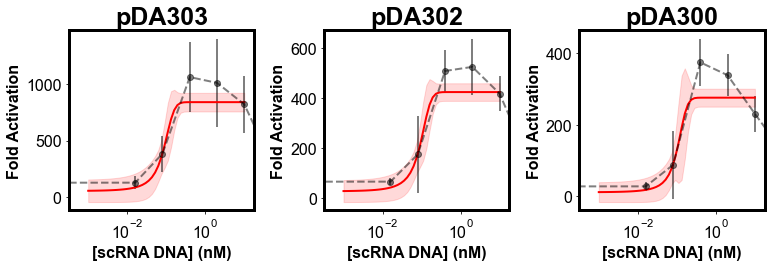

In [57]:
plt.figure(figsize=(11,4))

x = sum([[c,c,c] for c in conc],[])
labels = ['pDA303','pDA302','pDA300']

for i,F in enumerate([fa303,fa302,fa300]):
    plt.subplot(1,3,i+1)
    y = sum([[fa.iloc[t].m,fa.iloc[t].m+fa.iloc[t].s,fa.iloc[t].m-fa.iloc[t].s] for fa in F.values()],[])
    step_mod = lmf.models.StepModel(form='logistic')
    pars = step_mod.guess(y[3:], x=x[3:])
    mod = step_mod
    out = mod.fit(y, pars, x=x, max_nfev = 500)
    xnew = np.logspace(-3,1)
    ynew = out.eval(x=xnew)
    yerr = out.eval_uncertainty(x = xnew)

    plt.plot(xnew, ynew, 'r-')
    plt.fill_between(xnew, ynew-yerr, ynew+yerr,color = 'red', alpha = 0.15)
    plt.errorbar(conc, [fa.iloc[t].m for fa in F.values()], [fa.iloc[t].s for fa in F.values()], fmt = 'ko--', alpha = 0.5)
    #plt.plot(conc, [fa.iloc[t].m for fa in F.values()],'o')
    plt.title(labels[i])
    
    IN = []
    OUT = []
    XL = []
    XR = []
    for L in range(len(xnew)):
        for R in range(len(xnew)):
            XR.append(xnew[::-1][R])
            XL.append(xnew[L])
            IN.append(xnew[::-1][R]/xnew[L])
            OUT.append(ynew[::-1][R]/ynew[L])

    IN = np.array(IN)
    OUT = np.array(OUT)

    IN2 = IN[IN>1]
    OUT = OUT[IN>1]
    print(max([o/i for o,i in zip(OUT,IN2)]))
    
    plt.xscale('log')
    plt.xlabel('[scRNA DNA] (nM)')
    plt.ylabel('Fold Activation')
    plt.legend(frameon=False)
    plt.xlim(([10**(-3.5), 10**(1.25)]))
plt.tight_layout()
plt.savefig('promoters.svg')

In [395]:
1000/(0.4/0.0016)

4.0

In [381]:
    
    IN = []
    OUT = []
    XL = []
    XR = []
    for L in range(len(xnew)):
        for R in range(len(xnew)):
            XR.append(xnew[::-1][R])
            XL.append(xnew[L])
            IN.append(xnew[::-1][R]/xnew[L])
            OUT.append(ynew[::-1][R]/ynew[L])

    IN = np.array(IN)
    OUT = np.array(OUT)

    IN2 = IN[IN>1]
    OUT = OUT[IN>1]
    print(max([o/i for o,i in zip(OUT,IN2)]))

1.6663498725698527

1.6663498725698527

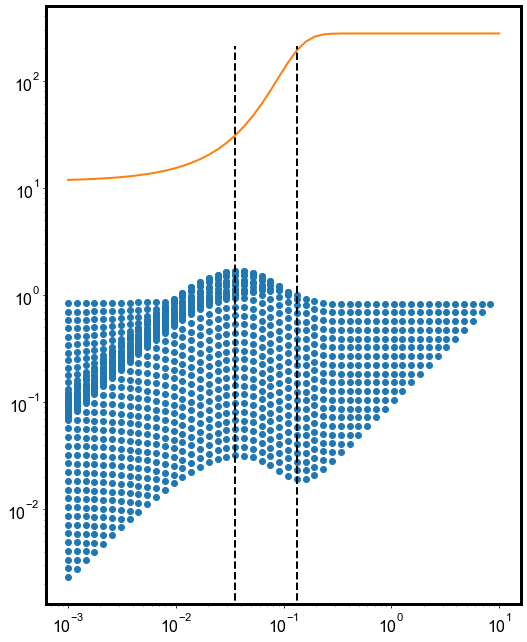

In [389]:
plt.plot((np.array(XL)[IN>1]),[o/i for o,i in zip(OUT,IN2)],'o')
plt.plot(xnew,ynew)
plt.xscale('log')
plt.yscale('log')

plt.plot([(np.array(XR)[IN>1])[np.argmax([o/i for o,i in zip(OUT,IN2)])],(np.array(XR)[IN>1])[np.argmax([o/i for o,i in zip(OUT,IN2)])]],[0,210],'k--')
plt.plot([(np.array(XL)[IN>1])[np.argmax([o/i for o,i in zip(OUT,IN2)])],(np.array(XL)[IN>1])[np.argmax([o/i for o,i in zip(OUT,IN2)])]],[0,210],'k--')


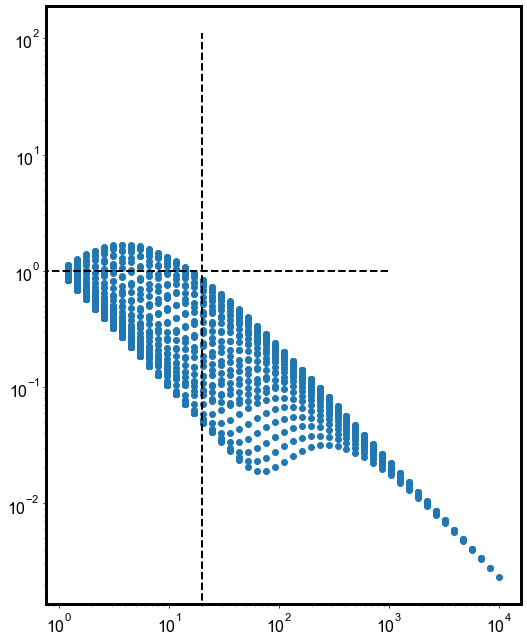

In [347]:
plt.plot(IN2,[o/i for o,i in zip(OUT,IN2)],'o')
plt.xscale('log')
plt.yscale('log')
plt.plot([20,20],[0,110],'k--')
plt.plot([0,1000],[1,1],'k--')

In [8]:
path = 'activatable promoters/txtl/'
file = '211209_pDA30x_titrations_TIDY.csv'
layout = '211209_pDA30x_titrations_LAYOUT.csv'
plate = pd.read_csv(path+layout, index_col = 0, dtype = str) # reads plate layout

labels = pd.unique(np.concatenate(plate.values))
tidy = pd.read_csv(path+file,index_col=0)

conc = [5,0.5,0.05,0.005,0.0005,0]

kinetics = get_kinetics(tidy, labels, 'RFPEx')

In [9]:
var = ['303','304','305','307','309', 'TJ1','blank']
data = {} 
for v in var:
    ids = [l for l in np.sort(labels) if v in l ]
    n = len(ids)
    da = np.empty((len(kinetics),n,3))
    for k,i in enumerate(ids):
        da[:,k,:] = kinetics[i].to_numpy()
        
    data[v] = da


[[<matplotlib.lines.Line2D at 0x1f4717d4af0>],

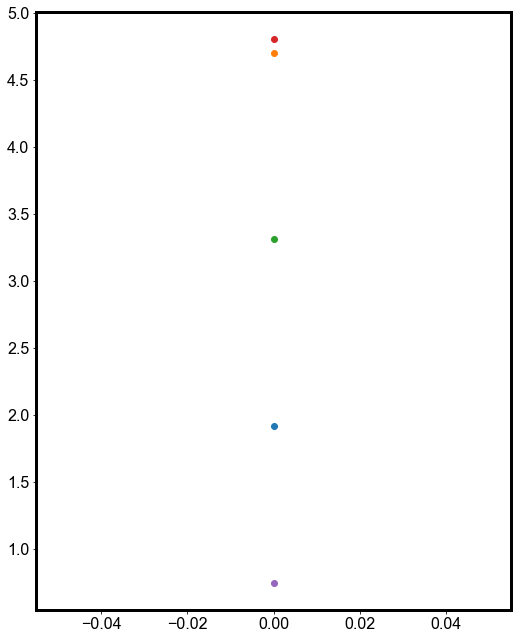

In [37]:
[plt.plot(data[v][t,-3,:].mean()/data[v][t,-1,:].mean(),'o') for v in var[:-2]]

Text(0, 0.5, 'Fold Change')

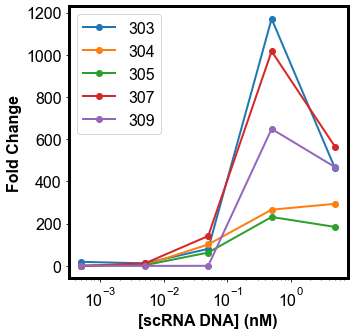

In [12]:
t = 111
rr = [0,1,1,1,0]
plt.figure(figsize = (5,5))
for v,r in zip(var[:-2],rr):
    plt.plot(conc[:-1],(data[v][t,:-1,r]-data['blank'][t,:,:].mean())/(data[v][t,-1,r]-data['blank'][t,:,:].mean()),'o-', label = v)
plt.legend()
plt.xscale('log')
plt.xlabel('[scRNA DNA] (nM)')
plt.ylabel('Fold Change')

In [130]:
[(data[v][t,-1,1]-data['blank'][t,:,:].mean())/(data['303'][t,-1,1]-data['blank'][t,:,:].mean()) for v in var[:-2]]

[1.0,
 1.6614173228346456,
 3.047244094488189,
 1.062992125984252,
 1.4173228346456692]

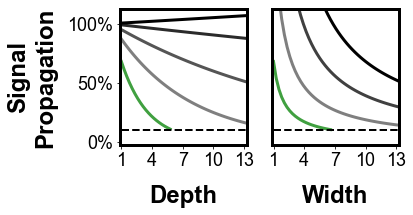

In [437]:
plt.figure(figsize=(5,2.5))

thresh = 0.1
fsp = [0.68,0.87,0.95,0.99, 1.005]
n = np.linspace(1,14)

colors = ['g','k','k','k','k']
alphas = [0.75] + list(np.linspace(0.5,1,4))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122, sharex = ax1)

for f,c,a in zip(fsp,colors, alphas):
    f = f**n
    f[f < 0.1] = np.nan
    ax1.plot(n, f, c, alpha = a, linewidth = 3)
    
ax1.plot([0,max(n)],[thresh, thresh],'k--')
ax1.set_ylim([-0.025,1.125])
ax1.set_xlim([0.85,max(n)-0.75])
ax1.set_ylabel('Signal\nPropagation', labelpad = ypad, size = 24, weight = 'bold')
ax1.set_xlabel('Depth', labelpad = xpad, size = 24, weight = 'bold')
ax1.set_xticks(np.arange(min(n),max(n),3))
ax1.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))
ax1.tick_params(axis='both', labelsize=18)

fc = [1,2.75,5.75,10]
colors = ['g','k','k','k']
alphas = [0.75] + list(np.linspace(0.5,1,3))

for f,c,a in zip(fc,colors, alphas):
    f = fsp[0]/n*f
    f[f < 0.1] = np.nan
    ax2.plot(n, f, c, alpha = a, linewidth = 3)

ax2.set_xlim([0.85,max(n)-0.75])
ax2.set_ylim([-0.025,1.125])
ax2.set_yticks([])
ax2.set_xlabel('Width', labelpad = xpad, size = 24, weight = 'bold')
ax2.set_xticks(np.arange(min(n),max(n),3))
ax2.plot([0,max(n)],[thresh, thresh],'k--')
ax2.tick_params(axis='both', labelsize=18)


In [38]:
conc

[5, 0.5, 0.05, 0.005, 0.0005, 0]

In [41]:
[1.8,
0.6,
0.2,
0.05,
0.01,
0.001,
0]

[1.8, 0.6, 0.2, 0.05, 0.01, 0.001, 0]

In [728]:
path = 'activatable promoters/bl/txtl/'

file_d = path+'220409-CRISRPa-cascade.csv' # CSV file with raw data (open .txt in Excel, save as .csv)
file_l = path+'220409-CRISRPa-cascade_light.csv' # CSV file with raw data (open .txt in Excel, save as .csv)

layout_d = path+'220409-CRISRPa-cascade_PL.csv' # CSV file with plate layout
layout_l = path+'220409-CRISRPa-cascade_light_PL.csv' # CSV file with plate layout

plate_l = pd.read_csv(layout_l, index_col = 0, dtype = str) # reads plate layout
plate_d = pd.read_csv(layout_d, index_col = 0, dtype = str) # reads plate layout

# need to specify which rows to read for each measurment
RFPEx_d = pd.read_csv(file_d, skiprows = 68, nrows = 109,na_values = 'OVRFLW', encoding = "ISO-8859-1") # reads raw data file at specified rows
RFPEx_l = pd.read_csv(file_l, skiprows = 68, nrows = 1,na_values = 'OVRFLW', encoding = "ISO-8859-1") # reads raw data file at specified rows



In [729]:
# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate_d.values))
exps_d = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate_d[plate_d.isin([l])].stack().index
        exps_d[l] = []
        for i in index:
            exps_d[l].append(i[0] + i[1])
            
            
# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate_l.values))
exps_l = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate_l[plate_l.isin([l])].stack().index
        exps_l[l] = []
        for i in index:
            exps_l[l].append(i[0] + i[1])
            
            
exps_d # print dictionary to check 

{'p4': ['B2', 'C2', 'D2'],
 'p5': ['B3', 'C3', 'D3'],
 'p6': ['B4', 'C4', 'D4'],
 'p7': ['B5', 'C5', 'D5'],
 'p8': ['B6', 'C6', 'D6'],
 'p9': ['B7', 'C7', 'D7'],
 'p10': ['B8', 'C8', 'D8'],
 'blank': ['B11', 'C11', 'D11'],
 'p11': ['E2', 'F2', 'G2'],
 'p12': ['E3', 'F3', 'G3'],
 'p13': ['E4', 'F4', 'G4'],
 'p14': ['E5', 'F5', 'G5'],
 'p15': ['E6', 'F6', 'G6'],
 'p1': ['E10', 'F10', 'G10'],
 'p2': ['E11', 'F11', 'G11'],
 'p16': ['F7', 'G7', 'H7']}

In [730]:
m_d = {}
s_d = {}
m_l = {}
s_l = {}
for e in exps_d:
    m_d[e] = RFPEx_d[exps_d[e]].iloc[-1].mean() - RFPEx_d[exps_d['blank']].iloc[-1].mean()
    s_d[e] = (RFPEx_d[exps_d[e]].iloc[-1].std()**2 + RFPEx_d[exps_d['blank']].iloc[-1].std()**2)**0.5

for e in exps_l:
    m_l[e] = RFPEx_l[exps_l[e]].iloc[-1].mean() - RFPEx_l[exps_l['blank']].iloc[-1].mean()
    s_l[e] = (RFPEx_l[exps_l[e]].iloc[-1].std()**2 + RFPEx_l[exps_l['blank']].iloc[-1].std()**2)**0.5

In [731]:
win = ['p'+str(i) for i in range(4,11)]
woin = ['p'+str(i) for i in range(11,17)]
x = [38.6,12.867,3.217,0.804,0.201,0.05,0.013]

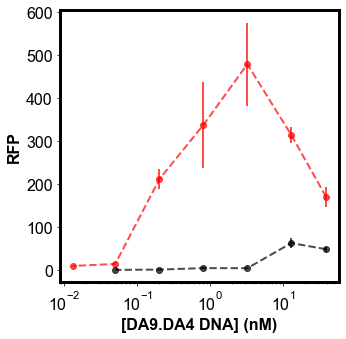

In [732]:
plt.figure(figsize = (5,5))
plt.errorbar(x,[m_d[p]/263.67 for p in win],yerr = [s_d[p]/263.67 for p in win], fmt = 'o--', color = 'r', alpha = 0.7)
plt.errorbar(x[:-1],[m_d[p]/263.67 for p in woin],yerr = [s_d[p]/263.67 for p in woin], fmt = 'o--', color = 'k', alpha = 0.7)
plt.xlabel('[DA9.DA4 DNA] (nM)')
plt.ylabel('RFP')
plt.xscale('log')
#plt.yscale('log')

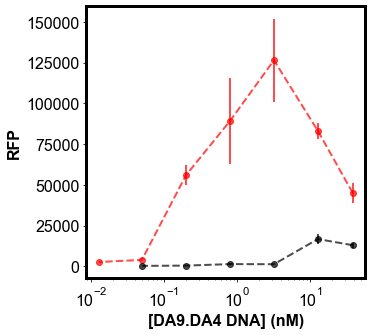

In [403]:
plt.figure(figsize = (5,5))
plt.errorbar(x,[m_d[p] for p in win],yerr = [s_d[p] for p in win], fmt = 'o--', color = 'r', alpha = 0.7)
plt.errorbar(x[:-1],[m_d[p] for p in woin],yerr = [s_d[p] for p in woin], fmt = 'o--', color = 'k', alpha = 0.7)
plt.xlabel('[DA9.DA4 DNA] (nM)')
plt.ylabel('RFP')
plt.xscale('log')
#plt.yscale('log')

Text(0, 0.5, 'Fold-Change')

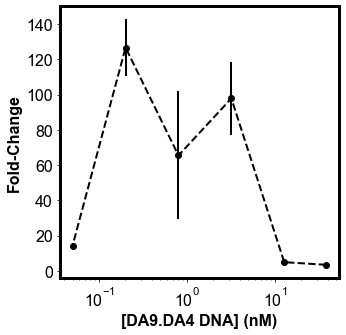

In [740]:
plt.figure(figsize = (5,5))
fc = np.array([a/b for a,b in zip([m_d[p] for p in win],[m_d[p] for p in woin])])
fce = np.array([((s1/m1)**2 + (s2/m2)**2)**0.5  for s1,m1,s2,m2 in zip([s_d[p] for p in win],[m_d[p] for p in win],[s_d[p] for p in woin],[m_d[p] for p in woin])])*fc
plt.errorbar(x[:-1],fc, fce, fmt = 'ko--')
plt.xscale('log')
plt.xlabel('[DA9.DA4 DNA] (nM)')
plt.ylabel('Fold-Change')

Text(0.5, 1.0, 'BL-MCP_SoxS  vs MCP_SoxS')

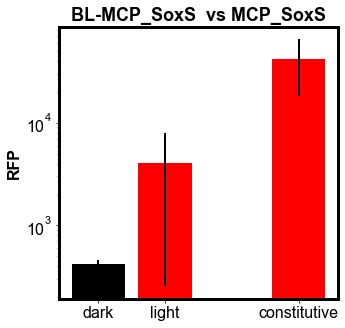

In [22]:
plt.figure(figsize = (5,5))
plt.bar([0,1,3],[m_d['p2'],m_l['p3'],m_d['p1']],yerr =[s_d['p2'],s_l['p3'],s_d['p1']], color = ['k','r','r'])
plt.yscale('log')
plt.xticks([0,1,3],['dark','light','constitutive'])
plt.ylabel('RFP')
plt.title('BL-MCP_SoxS  vs MCP_SoxS', fontsize = 18)

In [13]:
m_l['p3']/m_d['p2']

9.60219263899765

In [69]:
path = 'activatable promoters/txtl/node1_titration/'

file_d = path+'220509-CRISPRa-cascade-titration_plate2.csv' # CSV file with raw data (open .txt in Excel, save as .csv)
file_l = path+'220507-CRISPRa-cascade-titration.csv' # CSV file with raw data (open .txt in Excel, save as .csv)

layout_d = path+'220509_CRISPRa-cascade-titration_PL.csv' # CSV file with plate layout
layout_l = path+'220507_CRISPRa-cascade-titration_PL.csv' # CSV file with plate layout

plate_l = pd.read_csv(layout_l, index_col = 0, dtype = str) # reads plate layout
plate_d = pd.read_csv(layout_d, index_col = 0, dtype = str) # reads plate layout

# need to specify which rows to read for each measurment
columns = pd.read_csv(file_d, skiprows = 68, nrows = 1,na_values = 'OVRFLW', encoding = "ISO-8859-1").columns
RFPEx_d = pd.read_csv(file_d, skiprows = 154, nrows = 1,na_values = 'OVRFLW', encoding = "ISO-8859-1") # reads raw data file at specified rows
RFPEx_l = pd.read_csv(file_l, skiprows = 180, nrows = 1,na_values = 'OVRFLW', encoding = "ISO-8859-1") # reads raw data file at specified rows
RFPEx_d.columns = columns
RFPEx_l.columns = columns


In [70]:
# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate_d.values))
exps_d = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate_d[plate_d.isin([l])].stack().index
        exps_d[l] = []
        for i in index:
            exps_d[l].append(i[0] + i[1])
            
            
# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate_l.values))
exps_l = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate_l[plate_l.isin([l])].stack().index
        exps_l[l] = []
        for i in index:
            exps_l[l].append(i[0] + i[1])
            
            
exps_d # print dictionary to check 

{'control': ['A2', 'B2', 'C2'],
 'blank': ['B1', 'C1', 'D1'],
 'r_1': ['B3', 'C3', 'D3'],
 'r_4': ['B5', 'C5', 'D5'],
 'r_3': ['D4', 'E4', 'F4'],
 'c_1': ['D8', 'E8', 'F8'],
 'c_2': ['D9', 'E9', 'F9'],
 'c_3': ['D10', 'E10', 'F10'],
 'c_4': ['D11', 'E11', 'F11'],
 'TJ1': ['E1', 'F1', 'G1'],
 'r_2': ['E3', 'F3', 'G3'],
 'c_5': ['E12', 'F12', 'G12'],
 'r_5': ['G6', 'G7', 'G8'],
 'r_6': ['H6', 'H7', 'H8'],
 'c_6': ['H10', 'H11', 'H12']}

In [71]:
m_d = {}
s_d = {}
m_l = {}
s_l = {}
for e in exps_d:
    m_d[e] = RFPEx_d[exps_d[e]].iloc[-1].mean() - RFPEx_d[exps_d['blank']].iloc[-1].mean()
    s_d[e] = (RFPEx_d[exps_d[e]].iloc[-1].std()**2 + RFPEx_d[exps_d['blank']].iloc[-1].std()**2)**0.5

for e in exps_l:
    m_l[e] = RFPEx_l[exps_l[e]].iloc[-1].mean() - RFPEx_l[exps_l['blank']].iloc[-1].mean()
    s_l[e] = (RFPEx_l[exps_l[e]].iloc[-1].std()**2 + RFPEx_l[exps_l['blank']].iloc[-1].std()**2)**0.5

In [86]:
x_scRNA = [2,0.1,0.0333,0.0111,0.0037,0.0001]

Text(0.5, 1.0, 'Day 2')

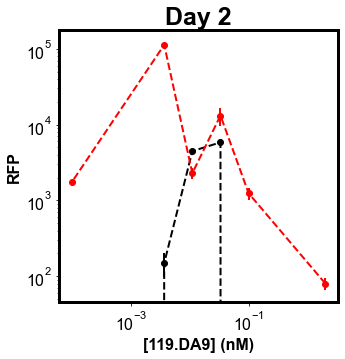

In [101]:
plt.figure(figsize = (5,5))
plt.errorbar(x_scRNA, [m_d[i] for i in ['r_'+str(k) for k in range(6,0,-1)]], yerr = [s_d[i] for i in ['r_'+str(k) for k in range(6,0,-1)]], fmt = 'ko--')
plt.errorbar(x_scRNA, [m_d[i] for i in ['c_'+str(k) for k in range(6,0,-1)]], yerr = [s_d[i] for i in ['c_'+str(k) for k in range(6,0,-1)]], fmt = 'ro--')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('RFP')
plt.xlabel('[119.DA9] (nM)')
plt.title('Day 2')

Text(0.5, 1.0, 'Day 1')

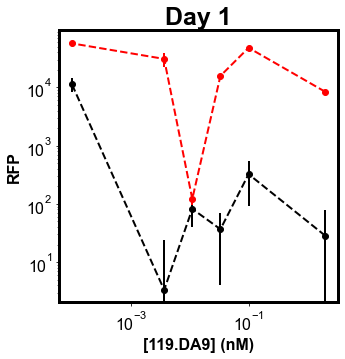

In [102]:
plt.figure(figsize = (5,5))
plt.errorbar(x_scRNA, [m_l[i] for i in ['r_'+str(k) for k in range(6,0,-1)]], yerr = [s_l[i] for i in ['r_'+str(k) for k in range(6,0,-1)]], fmt = 'ko--')
plt.errorbar(x_scRNA, [m_l[i] for i in ['c_'+str(k) for k in range(6,0,-1)]], yerr = [s_l[i] for i in ['c_'+str(k) for k in range(6,0,-1)]], fmt = 'ro--')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('RFP')
plt.xlabel('[119.DA9] (nM)')
plt.title('Day 1')

In [99]:
s_d['control']

132.594620303138

In [58]:
path = 'activatable promoters/txtl/node1_titration/'

file = path+'220510-CRISPRa-cascade-titration.csv' # CSV file with raw data (open .txt in Excel, save as .csv)

layout = path+'220510_CRISPRa-cascade-titration_PL.csv' # CSV file with plate layout

plate = pd.read_csv(layout, index_col = 0, dtype = str) # reads plate layout

# need to specify which rows to read for each measurment
columns = pd.read_csv(file, skiprows = 68, nrows = 1,na_values = 'OVRFLW', encoding = "ISO-8859-1").columns
RFPEx= pd.read_csv(file, skiprows = 183, nrows = 1,na_values = 'OVRFLW', encoding = "ISO-8859-1") # reads raw data file at specified rows
RFPEx.columns = columns


In [59]:
# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append(i[0] + i[1])
            
exps # print dictionary to check 

{'r_1': ['A1', 'B1', 'C1'],
 'r_4': ['A2', 'B2', 'C2'],
 'blank': ['A4', 'A5', 'B5'],
 'c_1': ['A9', 'A10', 'A11'],
 'c_5': ['A12', 'B12', 'C12'],
 'r_5': ['B3', 'C3', 'D3'],
 'c_2': ['B6', 'B7', 'B8'],
 'c_3': ['B9', 'B10', 'B11'],
 'c_4': ['C8', 'C10', 'C11'],
 'r_2': ['D1', 'E1', 'F1'],
 'r_7': ['D4', 'E4', 'F4'],
 'c_6': ['D9', 'D10', 'D11'],
 'r_6': ['E3', 'F3', 'G3'],
 'c_7': ['E8', 'E9', 'E10'],
 'c_8': ['F8', 'F9', 'F10'],
 'r_8': ['G4', 'G5', 'H4'],
 'r_3': ['H1', 'H2', 'H3']}

In [60]:
m = {}
s = {}

for e in exps:
    m[e] = RFPEx[exps[e]].iloc[-1].mean() - RFPEx[exps['blank']].iloc[-1].mean()
    s[e] = (RFPEx[exps[e]].iloc[-1].std()**2 + RFPEx[exps['blank']].iloc[-1].std()**2)**0.5

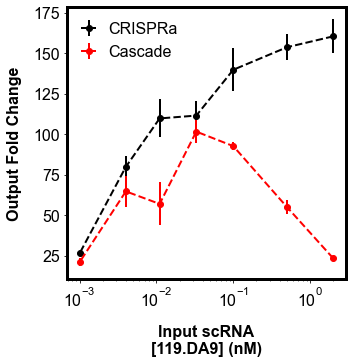

In [62]:
x_scRNA = [2,0.5,0.1,0.033,0.011,0.004,0.001]


plt.figure(figsize = (5,5))
plt.errorbar(x_scRNA, [m[i]/m['r_8'] for i in ['r_'+str(k) for k in range(1,8)]], yerr = [s[i]/m['r_8'] for i in ['r_'+str(k) for k in range(1,8)]], fmt = 'ko--')
plt.errorbar(x_scRNA, [m[i]/m['c_8'] for i in ['c_'+str(k) for k in range(1,8)]], yerr = [s[i]/m['c_8'] for i in ['c_'+str(k) for k in range(1,8)]], fmt = 'ro--')

plt.xscale('log')
plt.ylabel('Output Fold Change', labelpad = 1.1*ypad)
plt.xlabel('Input scRNA\n[119.DA9] (nM)', labelpad = xpad)
plt.legend(['CRISPRa', 'Cascade'], frameon = False, handlelength = 0.9, loc = 'upper left')
plt.savefig('competition-series.svg')

Text(0.5, 0, '[119.DA9] (nM)')

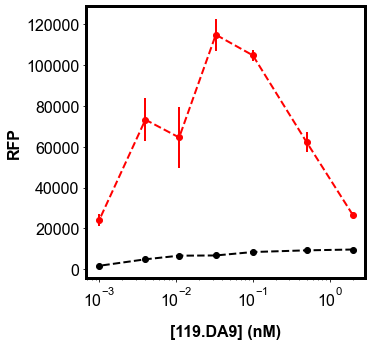

In [165]:
x_scRNA = [2,0.5,0.1,0.033,0.011,0.004,0.001]


plt.figure(figsize = (5,5))
plt.errorbar(x_scRNA, [m[i] for i in ['r_'+str(k) for k in range(1,8)]], yerr = [s[i] for i in ['r_'+str(k) for k in range(1,8)]], fmt = 'ko--')
plt.errorbar(x_scRNA, [m[i] for i in ['c_'+str(k) for k in range(1,8)]], yerr = [s[i] for i in ['c_'+str(k) for k in range(1,8)]], fmt = 'ro--')

plt.xscale('log')
plt.ylabel('RFP')
plt.xlabel('[119.DA9] (nM)', labelpad = xpad)
#plt.legend(['CRISPRa', 'CRISPRa Cascade'])

In [159]:
np.log10(0.05)

-1.3010299956639813

Text(0.5, 0, 'Input scRNA\n[119.DA9] (nM)')

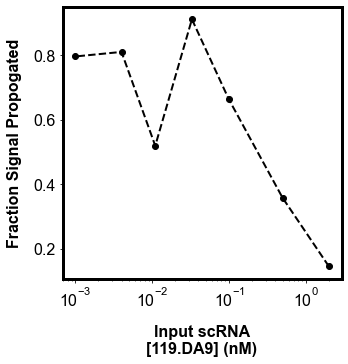

In [170]:
x_scRNA = [2,0.5,0.1,0.033,0.011,0.004,0.001]


plt.figure(figsize = (5,5))
plt.errorbar(x_scRNA, [(m['c_'+i]/m['c_8'])/(m['r_'+i]/m['r_8']) for i in [str(k) for k in range(1,8)]], fmt = 'ko--')

plt.xscale('log')
plt.ylabel('Fraction Signal Propogated', labelpad = 1.1*ypad)
plt.xlabel('Input scRNA\n[119.DA9] (nM)', labelpad = xpad)
#plt.legend(['CRISPRa', 'CRISPRa Cascade'])

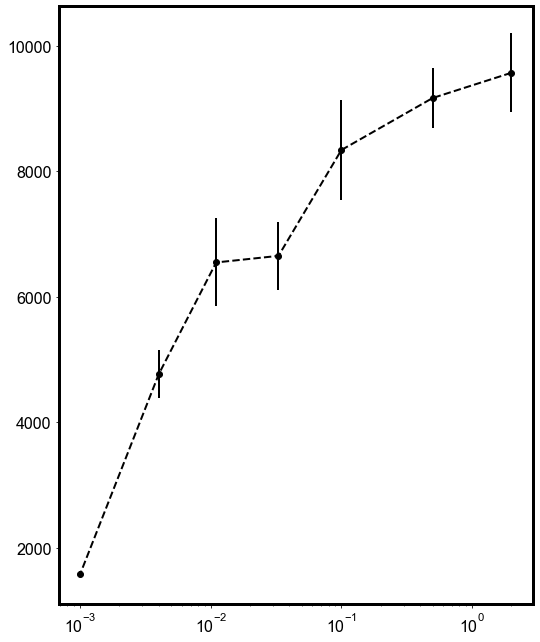

In [12]:
plt.errorbar(x_scRNA, [m[i] for i in ['r_'+str(k) for k in range(1,8)]], yerr = [s[i] for i in ['r_'+str(k) for k in range(1,8)]], fmt = 'ko--')
plt.xscale('log')

In [63]:
path = 'activatable promoters/txtl/competition-parallel/'

file = path+'220518-competition-parallel.csv' # CSV file with raw data (open .txt in Excel, save as .csv)

layout = path+'220518-competition-parallel_PL.csv' # CSV file with plate layout

plate = pd.read_csv(layout, index_col = 0, dtype = str) # reads plate layout

# need to specify which rows to read for each measurment
columns = pd.read_csv(file, skiprows = 76, nrows = 1,na_values = 'OVRFLW', encoding = "ISO-8859-1").columns
RFPEx= pd.read_csv(file, skiprows = 199, nrows = 1,na_values = 'OVRFLW', encoding = "ISO-8859-1") # reads raw data file at specified rows
GFP = pd.read_csv(file, skiprows = 518+123, nrows = 1,na_values = 'OVRFLW', encoding = "ISO-8859-1") # reads raw data file at specified rows

RFPEx.columns = columns
GFP.columns = columns


In [64]:
# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append(i[0] + i[1])
            
exps # print dictionary to check 

{'G0R0': ['A1', 'A2', 'A3'],
 'G1R0': ['A4', 'A5', 'C4'],
 'S1': ['A6', 'B6', 'C6'],
 'S2': ['A7', 'B7', 'C7'],
 'S3': ['A8', 'B8', 'C8'],
 'S4': ['A9', 'B9', 'C9'],
 'S5': ['A10', 'B10', 'C10'],
 'S6': ['A11', 'B11', 'C11'],
 'S7': ['A12', 'B12', 'C12'],
 'blank': ['B3', 'B4', 'B5'],
 'G1R1': ['C1', 'C2', 'C3'],
 'G1R2': ['D1', 'D2', 'D3'],
 'G0R1': ['D4', 'E4', 'F4'],
 'G0R2': ['D5', 'E5', 'F5'],
 'G1': ['D6', 'E6', 'F6'],
 'G2': ['D7', 'E7', 'F7'],
 'G3': ['D8', 'E8', 'F8'],
 'G4': ['D9', 'E9', 'F9'],
 'G5': ['D10', 'E10', 'F10'],
 'G6': ['D11', 'E11', 'F11'],
 'G7': ['D12', 'E12', 'F12'],
 'G1R3': ['E1', 'E2', 'E3'],
 'G1R4': ['F1', 'F2', 'F3'],
 'G1R5': ['G1', 'G3', 'G4'],
 'G0R5': ['G8', 'G9', 'G10'],
 'G0R6': ['G11', 'G12', 'H11'],
 'G1R6': ['H1', 'H2', 'H3'],
 'G0R3': ['H4', 'H5', 'H6'],
 'G0R4': ['H7', 'H8', 'H9']}

In [65]:
mR = {}
sR = {}
mG = {}
sG = {}
for e in exps:
    if len(e) > 2:
        mR[e] = RFPEx[exps[e]].iloc[-1].mean() - RFPEx[exps['blank']].iloc[-1].mean()
        sR[e] = (RFPEx[exps[e]].iloc[-1].std()**2 + RFPEx[exps['blank']].iloc[-1].std()**2)**0.5
        
        mG[e] = GFP[exps[e]].iloc[-1].mean() - GFP[exps['blank']].iloc[-1].mean()
        sG[e] = (GFP[exps[e]].iloc[-1].std()**2 + GFP[exps['blank']].iloc[-1].std()**2)**0.5
        
mpR = [1-mG['G1R'+str(i)]/mG['G0R'+str(i)] for i in range(7)]
spR = [(1-mpR[i])*((sG['G1R'+str(i)]/mG['G1R'+str(i)])**2 + (sG['G0R'+str(i)]/mG['G0R'+str(i)])**2)**0.5 for i in range(7)]

mfA = [mR['G1R'+str(i)]/mR['G0R0'] for i in range(7)]
sfA = [mfA[i]*((sR['G1R'+str(i)]/mR['G1R'+str(i)])**2+(sR['G0R0']/mR['G0R0'])**2)**0.5 for i in range(7)]

mfA2 = [mR['G0R'+str(i)]/mR['G0R0'] for i in range(7)]
sfA2 = [mfA[i]*((sR['G0R'+str(i)]/mR['G0R'+str(i)])**2+(sR['G0R0']/mR['G0R0'])**2)**0.5 for i in range(7)]

C:\Users\Diego Alba\.conda\envs\txtl-sim\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
C:\Users\Diego Alba\.conda\envs\txtl-sim\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Diego Alba\.conda\envs\txtl-sim\lib\site-packages\ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


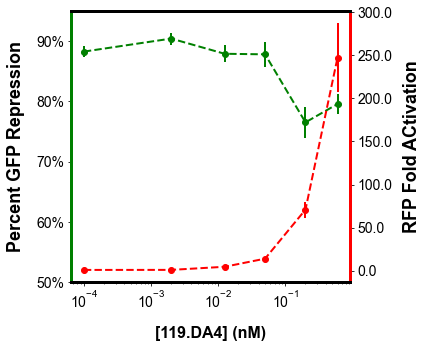

In [67]:
x_scRNA = [0.0001,0.002,0.0125,0.05,0.2,0.6,1.8]


plt.figure(figsize = (5,5))
plt.errorbar(x_scRNA[:-1],mpR[:-1],yerr = spR[:-1], fmt = 'go--')
plt.ylabel('Percent GFP Repression', fontsize = 18, labelpad= 1.1*ypad)
plt.ylim([0.5, 0.95])
plt.xlabel('[119.DA4] (nM)', labelpad = xpad, fontsize = 16)
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()], fontsize = 14)
plt.gca().set_xticklabels(plt.gca().get_xticks(), fontsize = 14)

ax2 = plt.gca().twinx()
plt.errorbar(x_scRNA[:-1],mfA[:-1],yerr = sfA[:-1], fmt = 'ro--')
plt.ylabel('RFP Fold ACtivation', fontsize = 18, labelpad = 1.1*ypad)
plt.xscale('log')
plt.gca().set_yticklabels(plt.gca().get_yticks(), fontsize = 14)

plt.gca().spines['left'].set_color('green')
plt.gca().spines['right'].set_color('red')

plt.savefig('competition-parallel.svg')

In [19]:
(RFPEx[exps['G1R4']].std(1))/(RFPEx[exps['G1R4']].mean(1))

0    0.120661
dtype: float64

C:\Users\Diego Alba\.conda\envs\txtl-sim\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


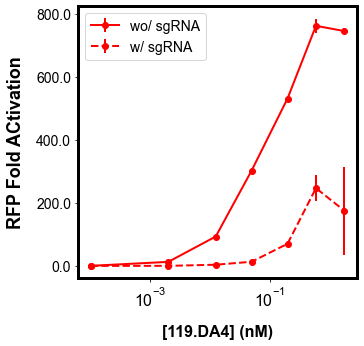

In [20]:
plt.figure(figsize = (5,5))
plt.errorbar(x_scRNA,mfA2,yerr = sfA2, fmt = 'ro-', label='wo/ sgRNA')
plt.errorbar(x_scRNA,mfA,yerr = sfA, fmt = 'ro--', label='w/ sgRNA')

plt.xlabel('[119.DA4] (nM)', labelpad = xpad, fontsize = 16)
plt.xscale('log')
plt.ylabel('RFP Fold ACtivation', fontsize = 18, labelpad = 1.1*ypad)
plt.gca().set_yticklabels(plt.gca().get_yticks(), fontsize = 14)
plt.legend(fontsize = 14)

In [29]:
# on average, including sgRNA reduced CRISPRa fold-change by 10x
np.mean(np.array(mfA2)/np.array(mfA))

10.59579804566801

In [91]:
path = 'activatable promoters/txtl/big_circuits/'

file = path+'220609-building-cascades.csv' # CSV file with raw data (open .txt in Excel, save as .csv)

layout = path+'220608_building_cascades_PL.csv' # CSV file with plate layout

plate = pd.read_csv(layout, index_col = 0, dtype = str) # reads plate layout

# need to specify which rows to read for each measurment
columns = pd.read_csv(file, skiprows = 68, nrows = 1,na_values = 'OVRFLW', encoding = "ISO-8859-1").columns
RFPEx= pd.read_csv(file, skiprows = 68, nrows = 129,na_values = 'OVRFLW', encoding = "ISO-8859-1") # reads raw data file at specified rows

RFPEx.columns = columns


In [92]:
# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append(i[0] + i[1])
            
exps # print dictionary to check 

{'E_0': ['A2', 'C2', 'D2'],
 'B_0': ['A3', 'B3', 'C3'],
 'B2_0': ['A4', 'B4', 'C4'],
 'D_0': ['A5', 'B5', 'D5'],
 'I_0': ['A6', 'B6', 'C6'],
 'c_0': ['A7', 'B7', 'C7'],
 'o_0': ['A8', 'B8', 'C8'],
 'p1_0': ['A9', 'B9', 'C9'],
 'p2_0': ['A10', 'B10', 'C10'],
 'cnt': ['A11', 'B11', 'C11'],
 'c_1': ['E7', 'F7', 'H7'],
 'p1_1': ['E9', 'F9', 'G9'],
 'p2_1': ['E10', 'F10', 'G10'],
 'blank': ['E11', 'F11', 'G11'],
 'E_1': ['F1', 'G1', 'H1'],
 'B_1': ['F3', 'G3', 'H3'],
 'B2_1': ['F4', 'G4', 'H4'],
 'D_1': ['F5', 'G5', 'H5'],
 'I_1': ['F6', 'G6', 'H6'],
 'o_1': ['F8', 'G8', 'H8']}

In [93]:
exps['E_1'] = exps['E_1'][:-1]

<AxesSubplot:>

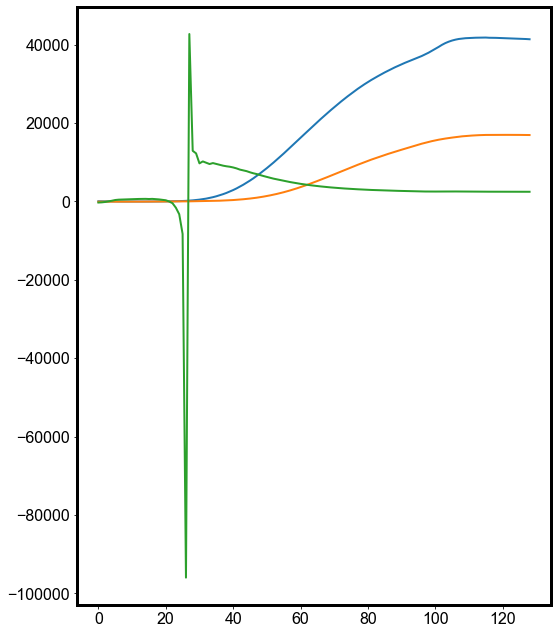

In [94]:
test0 = RFPEx[exps['B_0']].mean(1)- RFPEx[exps['cnt']].mean(1)
test1 = RFPEx[exps['B_1']].mean(1)- RFPEx[exps['cnt']].mean(1)
(test1.plot())
(test0.plot())
(1000*test1/test0).plot()

In [95]:
(test1/test0).iloc[40]

8.650300601202403

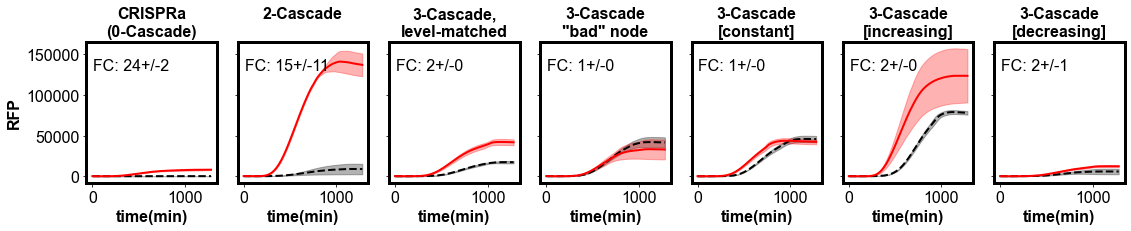

In [112]:
f,ax = plt.subplots(1,7,figsize = (16,3.5), sharey = True)
titles = ['CRISPRa\n(0-Cascade)', '2-Cascade\n', '3-Cascade,\nlevel-matched','3-Cascade\n"bad" node', '3-Cascade\n[constant]','3-Cascade\n[increasing]','3-Cascade\n[decreasing]']
for i,(l,t) in enumerate(zip(['c','p2','B','o','E','I','D'],titles)):
    m0 = RFPEx[exps[l+'_0']].mean(1) #- RFPEx[exps['cnt']].mean(1)
    s0 = (RFPEx[exps[l+'_0']].std(1)**2 + 0*RFPEx[exps['cnt']].std(1)**2)**0.5
    
    m1 = RFPEx[exps[l+'_1']].mean(1) #- RFPEx[exps['cnt']].mean(1)
    s1 = (RFPEx[exps[l+'_1']].std(1)**2 + 0*RFPEx[exps['cnt']].std(1)**2)**0.5
    
    ax[i].plot(range(0,(len(RFPEx))*10,10), m0, 'k--')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m0-s0,m0+s0, alpha = 0.3, color = 'k')
    
    ax[i].plot(range(0,(len(RFPEx))*10,10), m1, 'r-')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m1-s1,m1+s1, alpha = 0.3, color = 'r')
    
    fcarg = (m1/m0).argmax()
    fc = (m1/m0).iloc[-1]
    fce = fc*(((s1/m1)**2+(s0/m0)**2)**0.5).iloc[-1]
    
    ax[i].set_title(t, fontsize = 16)
    ax[i].text(10,130000,'FC: ' + str(round(fc))+'+/-'+str(round(fce)))
    ax[i].set_xlabel("time(min)")    

ax[0].set_ylabel("RFP")
ax[0].set_xlabel("time(min)")    

plt.tight_layout()

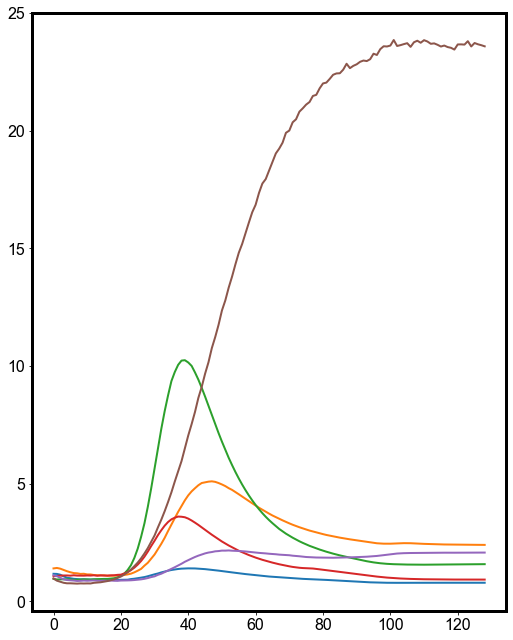

In [119]:
allm0 = []
allm1 = []
alls0 = []
alls1 = []
allt = []
allte = []

for i,l in enumerate(['o','B','I','E','D','c']):
    bs = 'cnt'
    if l == 'c': bs = 'blank'
        
    m0 = RFPEx[exps[l+'_0']].mean(1) - 0*RFPEx[exps[bs]].mean(1)
    s0 = (RFPEx[exps[l+'_0']].std(1)**2 + 0*RFPEx[exps[bs]].std(1)**2)**0.5
    
    m1 = RFPEx[exps[l+'_1']].mean(1) - 0*RFPEx[exps[bs]].mean(1)
    s1 = (RFPEx[exps[l+'_1']].std(1)**2 + 0*RFPEx[exps[bs]].std(1)**2)**0.5
    
    t10 = (m1-s1).ewm(span=7).mean().diff(3).argmax()
    t00 = (m0-s0).ewm(span=7).mean().diff(3).argmax()
    
    t11 = (m1+s1).ewm(span=7).mean().diff(3).argmax()
    t01 = (m0+s0).ewm(span=7).mean().diff(3).argmax()
    
    tm1 = np.mean([t10,t11])
    te1 = np.std([t10,t11])
    tm0 = np.mean([t00,t01])
    te0 = np.std([t00,t01])
    
    dt = tm0-tm1
    dte = (te1**2 + te0**2)**0.5

    allt.append(dt*10)
    allte.append(dte*10)
    plt.plot((m1/m0))
    fcarg = 100
    allm0.append(m0.iloc[fcarg])
    allm1.append(m1.iloc[fcarg])
    alls0.append(s0.iloc[fcarg])
    alls1.append(s1.iloc[fcarg])

allt[-1] = 0
allte[-1] = 0

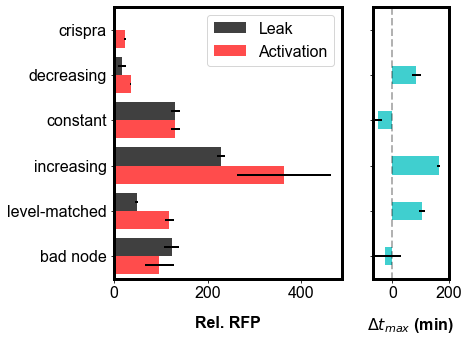

In [120]:
f, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, sharey = True, figsize = (6,5))

ax[0].barh(np.arange(6)+0.2,np.array(allm0)/allm0[-1], xerr = np.array(alls0)/allm0[-1], color = 'k', alpha= 0.75, height = 0.4)
ax[0].barh(np.arange(6)-0.2,np.array(allm1)/allm0[-1], xerr = np.array(alls1)/allm0[-1], color = 'r', alpha = 0.7, height = 0.4)
ax[0].set_yticks(range(6))
ax[0].set_yticklabels(['bad node','level-matched','increasing','constant','decreasing','crispra'])
ax[0].legend(['Leak','Activation'])
ax[0].set_xlabel('Rel. RFP',labelpad = xpad)

ax[1].barh(np.arange(6),allt, xerr = allte, color = 'c', alpha= 0.75, height = 0.4)
ax[1].set_xlim([-70,200])
ax[1].plot([0,0],[-1,6],'k--', alpha = 0.3)
ax[1].set_ylim([-0.5, 5.5])
ax[1].set_xlabel('$\Delta t_{max}$ (min)', labelpad = xpad)

plt.savefig('figures/cascade_strategies.svg')

In [124]:
allm0

[40907.666666666664,
 16063.333333333334,
 76010.66666666667,
 43616.333333333336,
 5873.333333333333,
 332.6666666666667]

In [125]:
76010.66666666667/16063.333333333334

4.731936086324964

In [370]:
path = 'activatable promoters/txtl/big_circuits/'

file = path+'220617-building-cascades_titrations.csv' # CSV file with raw data (open .txt in Excel, save as .csv)

layout = path+'220616_building_cascades_PL.csv' # CSV file with plate layout

plate = pd.read_csv(layout, index_col = 0, dtype = str) # reads plate layout

# need to specify which rows to read for each measurment
columns = pd.read_csv(file, skiprows = 68, nrows = 1,na_values = 'OVRFLW', encoding = "ISO-8859-1").columns
RFPEx= pd.read_csv(file, skiprows = 68, nrows = 116,na_values = 'OVRFLW', encoding = "ISO-8859-1") # reads raw data file at specified rows

RFPEx.columns = columns


In [371]:
# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append(i[0] + i[1])
            
exps # print dictionary to check 

{'cnt': ['A1', 'B1', 'C1'],
 'blank': ['A2', 'B2', 'C2'],
 'cL_1': ['A4', 'B4', 'D4'],
 'MM_1': ['A5', 'B5', 'C5'],
 'HM_1': ['A6', 'B6', 'C6'],
 'LH_1': ['A7', 'B7', 'C7'],
 'MH_1': ['A8', 'B8', 'C8'],
 'HH_1': ['A9', 'B9', 'C9'],
 'LL_1': ['A10', 'B10', 'C10'],
 'ML_1': ['A11', 'B11', 'C11'],
 'HL_1': ['A12', 'B12', 'C12'],
 'cL_0': ['B3', 'C3', 'D3'],
 'B_0': ['D1', 'E1', 'E2'],
 'MM_0': ['D5', 'E5', 'F5'],
 'HM_0': ['D6', 'E6', 'F6'],
 'LH_0': ['D7', 'E7', 'F7'],
 'MH_0': ['D8', 'E8', 'F8'],
 'HH_0': ['D9', 'E9', 'F9'],
 'LL_0': ['D10', 'E10', 'F10'],
 'ML_0': ['D11', 'E11', 'F11'],
 'B_3': ['E3', 'F3', 'G3'],
 'cM_0': ['E4', 'F4', 'G4'],
 'HL_0': ['E12', 'F12', 'G12', 'H12'],
 'B_1': ['F1', 'G1', 'H1'],
 'B_2': ['G2', 'H2', 'H3'],
 'cM_1': ['G5', 'G6', 'G7'],
 'cH_0': ['H6', 'H7', 'H8'],
 'cH_1': ['H9', 'H10', 'H11']}

In [372]:
exps['HM_0'] = exps['HM_0'][1:]
exps['B_1'] = exps['B_1'][:-1]

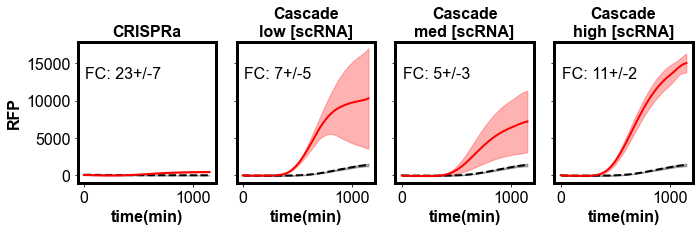

In [373]:
f,ax = plt.subplots(1,4, figsize = (10,3.5), sharey = True)
titles = ['CRISPRa', 'Cascade\nlow [scRNA]','Cascade\nmed [scRNA]','Cascade\nhigh [scRNA]']
for i,(l,t) in enumerate(zip(['cL','B_1','B_2','B_3'],titles)):
    if 'B' in l:
        m0 = RFPEx[exps['B_0']].mean(1) - RFPEx[exps['cnt']].mean(1)
        s0 = (RFPEx[exps['B_0']].std(1)**2 + RFPEx[exps['cnt']].std(1)**2)**0.5
        
        m1 = RFPEx[exps[l]].mean(1) - RFPEx[exps['cnt']].mean(1)
        s1 = (RFPEx[exps[l]].std(1)**2 + RFPEx[exps['cnt']].std(1)**2)**0.5
        
    else:
        m0 = RFPEx[exps[l+'_0']].mean(1) - RFPEx[exps['blank']].mean(1)
        s0 = (RFPEx[exps[l+'_0']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5

        m1 = RFPEx[exps[l+'_1']].mean(1) - RFPEx[exps['blank']].mean(1)
        s1 = (RFPEx[exps[l+'_1']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5
    
    ax[i].plot(range(0,(len(RFPEx))*10,10), m0, 'k--')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m0-s0,m0+s0, alpha = 0.3, color = 'k')
    
    ax[i].plot(range(0,(len(RFPEx))*10,10), m1, 'r-')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m1-s1,m1+s1, alpha = 0.3, color = 'r')

    fc = (m1/m0).iloc[-1]
    fce = fc*(((s1/m1)**2+(s0/m0)**2)**0.5).iloc[-1]
    
    ax[i].set_title(t, fontsize = 16)
    ax[i].text(10,13000,'FC: ' + str(round(fc))+'+/-'+str(round(fce)))
    ax[i].set_xlabel("time(min)")    

ax[0].set_ylabel("RFP")
ax[0].set_xlabel("time(min)")    

plt.tight_layout()

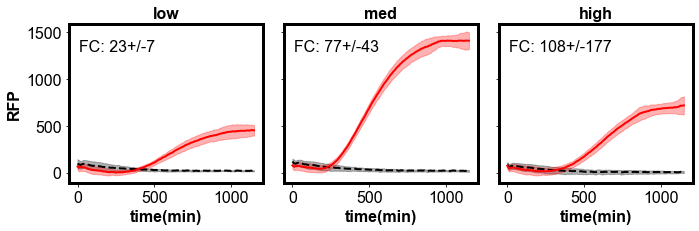

In [162]:
f,ax = plt.subplots(1,3, figsize = (10,3.5), sharey = True)
titles = ['low','med','high']
for i,(l,t) in enumerate(zip(['cL','cM','cH'],titles)):

    m0 = RFPEx[exps[l+'_0']].mean(1) - RFPEx[exps['blank']].mean(1)
    s0 = (RFPEx[exps[l+'_0']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5

    m1 = RFPEx[exps[l+'_1']].mean(1) - RFPEx[exps['blank']].mean(1)
    s1 = (RFPEx[exps[l+'_1']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5
    
    ax[i].plot(range(0,(len(RFPEx))*10,10), m0, 'k--')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m0-s0,m0+s0, alpha = 0.3, color = 'k')
    
    ax[i].plot(range(0,(len(RFPEx))*10,10), m1, 'r-')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m1-s1,m1+s1, alpha = 0.3, color = 'r')

    fc = (m1/m0).iloc[-1]
    fce = fc*(((s1/m1)**2+(s0/m0)**2)**0.5).iloc[-1]
    
    ax[i].set_title(t, fontsize = 16)
    ax[i].text(10,1300,'FC: ' + str(round(fc))+'+/-'+str(round(fce)))
    ax[i].set_xlabel("time(min)")    

ax[0].set_ylabel("RFP")
ax[0].set_xlabel("time(min)")    

plt.tight_layout()

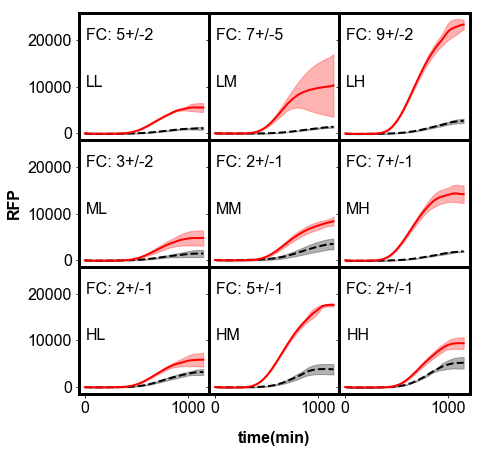

In [384]:
f,ax = plt.subplots(3,3, figsize = (7,7), sharey = True, sharex=True)

leaks = np.zeros((3,3))
acts = np.zeros((3,3))
leakse = np.zeros((3,3))
actse = np.zeros((3,3))
fcm = np.zeros((3,3))
fcme = np.zeros((3,3))

for i,l in enumerate(['L','M','H']):
    for j,ll in enumerate(['L','M','H']):#
        label = l+ll
        if label == 'LM': label = 'B'
            
        m0 = RFPEx[exps[label+'_0']].mean(1) - RFPEx[exps['cnt']].mean(1)
        s0 = (RFPEx[exps[label+'_0']].std(1)**2 + RFPEx[exps['cnt']].std(1)**2)**0.5

        m1 = RFPEx[exps[label+'_1']].mean(1) - RFPEx[exps['cnt']].mean(1)
        s1 = (RFPEx[exps[label+'_1']].std(1)**2 + RFPEx[exps['cnt']].std(1)**2)**0.5

        ax[i,j].plot(range(0,(len(RFPEx))*10,10), m0, 'k--')
        ax[i,j].fill_between(range(0,(len(RFPEx))*10,10), m0-s0,m0+s0, alpha = 0.3, color = 'k')

        ax[i,j].plot(range(0,(len(RFPEx))*10,10), m1, 'r-')
        ax[i,j].fill_between(range(0,(len(RFPEx))*10,10), m1-s1,m1+s1, alpha = 0.3, color = 'r')

        fc = (m1/m0).iloc[-1]
        fce = fc*(((s1/m1)**2+(s0/m0)**2)**0.5).iloc[-1]

        ax[i,j].text(10,20000,'FC: ' + str(round(fc))+'+/-'+str(round(fce)))
        ax[i,j].text(10,10000,l+ll)
        
        leaks[i,j] = m0.iloc[-1]/(RFPEx[exps['cH_0']].mean(1).iloc[-1]-RFPEx[exps['blank']].mean(1).iloc[-1])
        acts[i,j] = m1.iloc[-1]/(RFPEx[exps['cH_0']].mean(1).iloc[-1]-RFPEx[exps['blank']].mean(1).iloc[-1])
        leakse[i,j] = s0.iloc[-1]/(RFPEx[exps['cH_0']].mean(1).iloc[-1]-RFPEx[exps['blank']].mean(1).iloc[-1])
        actse[i,j] = s1.iloc[-1]/(RFPEx[exps['cH_0']].mean(1).iloc[-1]-RFPEx[exps['blank']].mean(1).iloc[-1])
        fcm[i,j] = fc
        fcme[i,j] = fce

f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

plt.ylabel("RFP", labelpad = ypad*2.75)
plt.xlabel("time(min)", labelpad = xpad)    

plt.subplots_adjust(hspace = 0, wspace = 0)

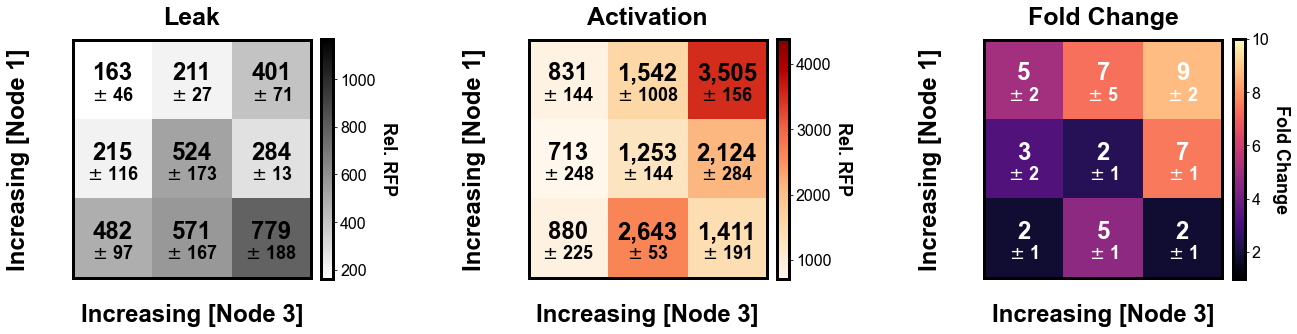

In [389]:
plt.figure(figsize = (21,7))
plt.subplot(1,3,1)
plt.imshow(leaks, cmap = 'binary', vmax = np.max(leaks)*1.5)
plt.colorbar(fraction=0.046, pad=0.04).ax.set_ylabel('Rel. RFP', rotation=270, labelpad = ypad*2.1, size = 18)
for i in range(3):
    for j in range(3):
        plt.text(j, i-0.075, '{:,.0f}'.format(leaks[i, j]),ha="center", va="center", color = 'k', fontweight ='bold', size = 24)
        plt.text(j, i+0.2, '$\pm$ %.0f' % leakse[i,j],ha='center',va='center', color = 'k',fontweight ='bold', size = 18)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Increasing [Node 3]', size = 24)
plt.ylabel('Increasing [Node 1]', size = 24)
plt.title('Leak', pad = xpad)

plt.subplot(1,3,2)
plt.imshow(acts, cmap = 'OrRd', vmax = np.max(acts)*1.25)
plt.colorbar(fraction=0.046, pad=0.04).ax.set_ylabel('Rel. RFP', rotation=270, labelpad = ypad*2.1, size = 18)
for i in range(3):
    for j in range(3):
        plt.text(j, i-0.075, '{:,.0f}'.format(acts[i, j]),ha="center", va="center", color = 'k', fontweight ='bold', size = 24)
        plt.text(j, i+0.2, '$\pm$ %.0f' % actse[i,j],ha='center',va='center', color = 'k',fontweight ='bold', size = 18)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Increasing [Node 3]', size = 24)
plt.ylabel('Increasing [Node 1]', size = 24)
plt.title('Activation', pad = xpad)   

plt.subplot(1,3,3)
plt.imshow(fcm,cmap = 'magma', vmin = 1, vmax = 10)
plt.colorbar(fraction=0.046, pad=0.04).ax.set_ylabel('Fold Change', rotation=270, labelpad = ypad*2.1, size = 18)
for i in range(3):
    for j in range(3):
        plt.text(j, i-0.075, '{:,.0f}'.format(fcm[i, j]),ha="center", va="center", color = 'w', fontweight ='bold', size = 24)
        plt.text(j, i+0.2, '$\pm$ %.0f' % fcme[i,j],ha='center',va='center', color = 'w',fontweight ='bold', size = 18)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Increasing [Node 3]', size = 24)
plt.ylabel('Increasing [Node 1]', size = 24)
plt.title('Fold Change', pad = xpad)

plt.subplots_adjust(hspace = 0, wspace = 0.75)
plt.savefig('figures/cascade_titrations.svg')

In [397]:
9/23

0.391304347826087

In [413]:
path = 'activatable promoters/txtl/big_circuits/'

file = path+'220622-fans_and_cascades.csv' # CSV file with raw data (open .txt in Excel, save as .csv)

layout = path+'220622-fans_and_cascades_PL.csv' # CSV file with plate layout

plate = pd.read_csv(layout, index_col = 0, dtype = str) # reads plate layout

# need to specify which rows to read for each measurment
columns = pd.read_csv(file, skiprows = 68, nrows = 1,na_values = 'OVRFLW', encoding = "ISO-8859-1").columns
RFPEx= pd.read_csv(file, skiprows = 68, nrows = 127,na_values = 'OVRFLW', encoding = "ISO-8859-1") # reads raw data file at specified rows

RFPEx.columns = columns


In [414]:
RFPEx

,Time,"T° RFP-Ex:540/35,600/40",A1,A2,A3,A4,A5,A6,A7,A8,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,0:00:00,29.1,491,443,481,358,336,452,444,332,...,222,233,236,239,227,230,228,224,235,242
1,0:10:00,29.0,492,437,479,353,314,436,435,329,...,221,233,235,238,225,227,225,220,234,239
2,0:20:00,29.0,487,426,476,347,302,423,429,312,...,220,233,235,238,227,224,225,221,236,238
3,0:30:00,29.0,486,412,471,344,297,409,421,303,...,219,230,231,237,226,224,225,220,232,240
4,0:40:00,29.0,475,396,467,342,290,395,410,299,...,217,231,232,237,226,226,223,220,235,236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,20:20:00,29.0,140520,171472,309385,305361,56536,247590,233332,232868,...,242,245,247,249,237,234,232,228,242,248
123,20:30:00,29.0,140436,171429,308758,305784,56542,247900,233392,232825,...,241,248,247,250,238,233,232,229,243,247
124,20:40:00,29.0,140608,171450,309168,305660,56577,247816,233478,233064,...,241,246,245,248,238,234,232,229,240,247
125,20:50:00,29.0,140502,171427,308401,305547,56549,247407,233533,233098,...,242,248,246,248,240,232,233,229,242,246


In [415]:
# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append(i[0] + i[1])
            
exps # print dictionary to check 

{'LH_0': ['A1', 'B1', 'C1'],
 'LH_1': ['A2', 'B2', 'C2'],
 'LH_2': ['A3', 'B3', 'C3'],
 'LH_3': ['A4', 'B4', 'C4'],
 'lowLH_0': ['A5', 'B5', 'C5'],
 'lowLH_1': ['A6', 'B6', 'C6'],
 'highLH_0': ['A7', 'B7', 'C7'],
 'highLH_1': ['A8', 'B8', 'C8'],
 'c_1': ['A9', 'B9', 'C9'],
 'c_0': ['A10', 'B10', 'C10'],
 'blank': ['A11', 'B11', 'C11'],
 '1p_A_pos': ['D1', 'E1', 'F1'],
 '1p_A_neg': ['D2', 'E2', 'F2'],
 '2p_eq_A_pos': ['D3', 'E3', 'F3'],
 '2p_eq_A_neg': ['D4', 'E4', 'F4'],
 '2p_half_A_pos': ['D5', 'E5', 'F5'],
 '2p_half_A_neg': ['D6', 'E6', 'F6'],
 '3p_eq_A_pos': ['D7', 'E7', 'F7'],
 '3p_eq_A_neg': ['D8', 'E8', 'F8'],
 '3p_third_A_pos': ['D9', 'E9', 'F9'],
 '3p_third_A_neg': ['D10', 'E10', 'F10'],
 '4p_eq_A_pos': ['D11', 'E11', 'F11'],
 '4p_eq_A_neg': ['D12', 'E12', 'F12'],
 '4p_fourth_A_pos': ['G1', 'G2', 'G3'],
 '4p_fourth_A_neg': ['G4', 'G5', 'G6'],
 'leak': ['G10', 'G11', 'G12']}

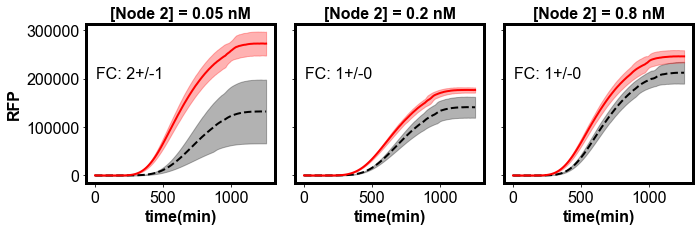

In [473]:
f,ax = plt.subplots(1,3, figsize = (10,3.5), sharey = True)
titles = ['0.05','0.2','0.8']
for i,(l,t) in enumerate(zip(['low','','high'],titles)):

    m0 = RFPEx[exps[l+'LH_0']].mean(1) - RFPEx[exps['blank']].mean(1)
    s0 = (RFPEx[exps[l+'LH_0']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5

    m1 = RFPEx[exps[l+'LH_1']].mean(1) - RFPEx[exps['blank']].mean(1)
    s1 = (RFPEx[exps[l+'LH_1']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5
    
    ax[i].plot(range(0,(len(RFPEx))*10,10), m0, 'k--')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m0-s0,m0+s0, alpha = 0.3, color = 'k')
    
    ax[i].plot(range(0,(len(RFPEx))*10,10), m1, 'r-')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m1-s1,m1+s1, alpha = 0.3, color = 'r')

    fc = (m1/m0).iloc[-1]
    fce = fc*(((s1/m1)**2+(s0/m0)**2)**0.5).iloc[-1]
    
    ax[i].set_title('[Node 2] = '+t+' nM', fontsize = 16)
    ax[i].text(10,200000,'FC: ' + str(round(fc))+'+/-'+str(round(fce)))
    ax[i].set_xlabel("time(min)")    

ax[0].set_ylabel("RFP")
ax[0].set_xlabel("time(min)")    

plt.tight_layout()

1.0
1.2535891285456187
1.9434145440510326
2.29181633701698


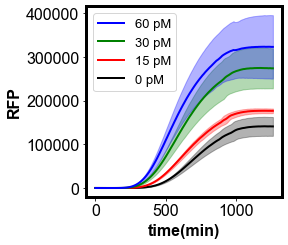

In [469]:
f,ax = plt.subplots(1,1, figsize = (3.5,3.5), sharey = True)
labels = ['0 pM', '15 pM', '30 pM', '60 pM']
for i,l in enumerate(['k','r','g','b']):
    m0 = RFPEx[exps['LH_0']].mean(1) - RFPEx[exps['blank']].mean(1)
    s0 = (RFPEx[exps['LH_0']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5

    m1 = RFPEx[exps['LH_'+str(i)]].mean(1) - RFPEx[exps['blank']].mean(1)
    s1 = (RFPEx[exps['LH_'+str(i)]].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5
    
    ax.plot(range(0,(len(RFPEx))*10,10), m1, l+'-', label = labels[i])
    ax.fill_between(range(0,(len(RFPEx))*10,10), m1-s1,m1+s1, alpha = 0.3, color = l)

    fc = (m1/m0).iloc[-1]
    fce = fc*(((s1/m1)**2+(s0/m0)**2)**0.5).iloc[-1]
    print(fc)
    ax.set_xlabel("time(min)")  
    
ax.set_ylabel("RFP")
ax.set_xlabel("time(min)")    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', prop={'size': 13})

In [496]:
path = 'activatable promoters/txtl/big_circuits/'

file = path+'220627_CRISPRa_cascades.csv' # CSV file with raw data (open .txt in Excel, save as .csv)

layout = path+'220627_CRISPRa_cascades_PL.csv' # CSV file with plate layout

plate = pd.read_csv(layout, index_col = 0, dtype = str) # reads plate layout

# need to specify which rows to read for each measurment
columns = pd.read_csv(file, skiprows = 76, nrows = 1,na_values = 'OVRFLW', encoding = "ISO-8859-1").columns
RFPEx= pd.read_csv(file, skiprows = 76, nrows = 132,na_values = 'OVRFLW', encoding = "ISO-8859-1") # reads raw data file at specified rows

RFPEx.columns = columns


In [498]:
# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append(i[0] + i[1])
            
exps # print dictionary to check 

{'c1_0': ['A1', 'A2', 'A3'],
 'c5_0': ['A4', 'A5', 'A6'],
 'c0_0': ['A7', 'A8', 'A9'],
 'HB_c5_0': ['A10', 'A11', 'A12'],
 'c2_0': ['B1', 'B2', 'B3'],
 'c5_1': ['B4', 'B5', 'B6'],
 'c0_1': ['B7', 'B8', 'B9'],
 'HB_c5_1': ['B10', 'B11', 'B12'],
 'c3_0': ['C1', 'C2', 'C3'],
 'c5_2': ['C4', 'C5', 'C6'],
 'c0_2': ['C7', 'C8', 'C9'],
 'HL_c5_0': ['C10', 'C11', 'C12'],
 'c4_0': ['D1', 'D2', 'D3'],
 'c5_3': ['D4', 'D5', 'D6'],
 'c0_3': ['D7', 'D8', 'D9'],
 'HL_c5_1': ['D10', 'D11', 'D12'],
 'c1_1': ['E1', 'E2', 'E3'],
 'c5_4': ['E4', 'E5', 'E6'],
 'c0_4': ['E7', 'E8', 'E9'],
 'LL_c5_0': ['E10', 'E11', 'E12'],
 'c2_1': ['F1', 'F2', 'F3'],
 'c5_5': ['F4', 'F5', 'F6'],
 'c0_5': ['F7', 'F8', 'F9'],
 'LL_c5_1': ['F10', 'F11', 'F12'],
 'c3_1': ['G1', 'G2', 'G3'],
 'c5_6': ['G4', 'G5', 'G6'],
 'c0_6': ['G7', 'G8', 'G9'],
 'blank': ['G10', 'G11', 'G12'],
 'c4_1': ['H1', 'H2', 'H3'],
 'c5_7': ['H4', 'H5', 'H6'],
 'c0_7': ['H7', 'H8', 'H9']}

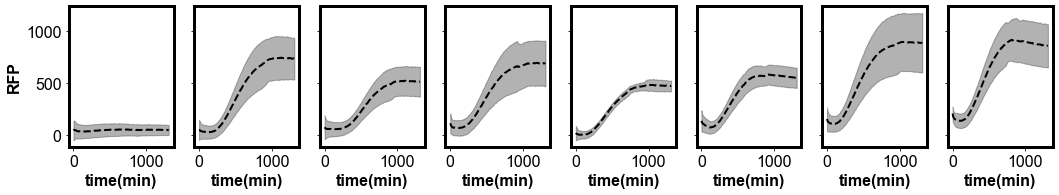

In [542]:
f,ax = plt.subplots(1,8, figsize = (15,3), sharey = True)
ym306 = []
ye306 = []

for i in range(8):
    i = str(i)
    m0 = RFPEx[exps['c0_'+i]].mean(1) - RFPEx[exps['blank']].mean(1)
    s0 = (RFPEx[exps['c0_'+i]].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5

    i = int(i)
    ax[i].plot(range(0,(len(RFPEx))*10,10), m0, 'k--')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m0-s0,m0+s0, alpha = 0.3, color = 'k')
    
    ax[i].set_xlabel("time(min)")
    ym306.append(m0.iloc[-1])
    ye306.append(s0.iloc[-1])

ax[0].set_ylabel("RFP")
ax[0].set_xlabel("time(min)")    

plt.tight_layout()

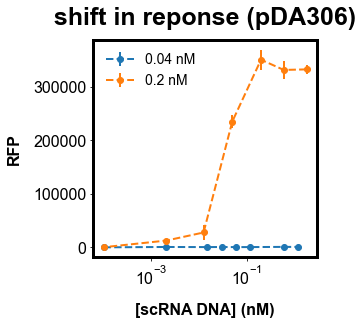

In [571]:
# pDA306 @ 0.04nM

high306m = np.array([3.32795333e+05, 3.31771000e+05, 3.50917667e+05, 2.35313000e+05,2.78286667e+04, 1.27656667e+04, 2.63666667e+02])
high306e = np.array([7.75596439e+03, 1.74692580e+04, 1.87112869e+04, 1.27561242e+04,1.42203653e+04, 2.45347128e+03, 9.18331821e+00])
x_old = [1.8,0.6,0.2,0.05,0.0125,0.002083333, 0.0001]

x_new = [0.0001,0.002,0.015,0.03,0.06,0.12,0.6,1.2] # real 0
ym306 = np.array(ym306)
ye306 = np.array(ye306)

plt.figure(figsize = (4,4))
plt.errorbar(x_new, ym306, ye306, fmt ='o--', label = '0.04 nM')
plt.errorbar(x_old, high306m, high306e, fmt ='o--', label = '0.2 nM')

plt.xscale('log')
plt.xlabel('[scRNA DNA] (nM)', labelpad = xpad)
plt.ylabel('RFP', labelpad = ypad*1.1)
plt.title('shift in reponse (pDA306)', pad = xpad)
plt.legend(frameon = False, fontsize = 14, loc = 'upper left')

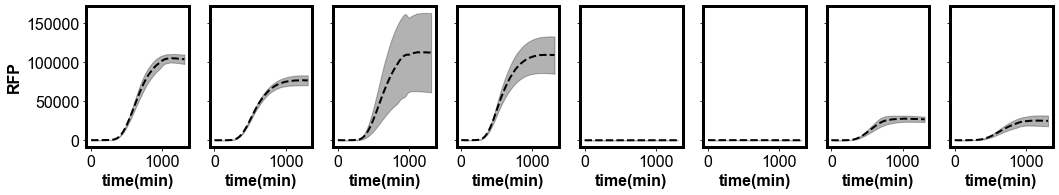

In [507]:
f,ax = plt.subplots(1,8, figsize = (15,3), sharey = True)
for i in range(8):
    i = str(i)
    m0 = RFPEx[exps['c5_'+i]].mean(1) - RFPEx[exps['blank']].mean(1)
    s0 = (RFPEx[exps['c5_'+i]].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5

    i = int(i)
    ax[i].plot(range(0,(len(RFPEx))*10,10), m0, 'k--')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m0-s0,m0+s0, alpha = 0.3, color = 'k')
    
    ax[i].set_xlabel("time(min)")    

ax[0].set_ylabel("RFP")
ax[0].set_xlabel("time(min)")    

plt.tight_layout()

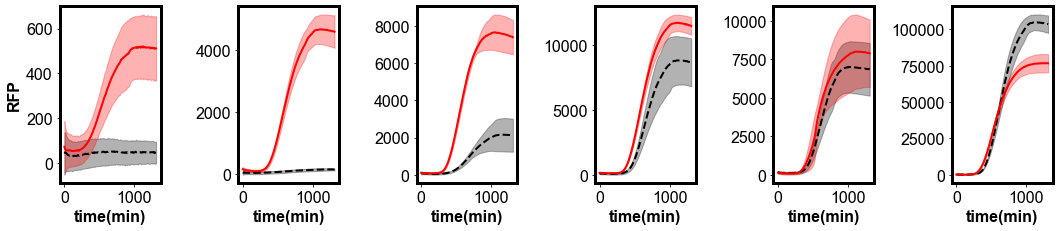

In [517]:
f,ax = plt.subplots(1,6, figsize = (15,3.5), sharey = False)
for i in range(6):
    i = str(i)
    m0 = RFPEx[exps['c'+i+'_0']].mean(1) - RFPEx[exps['blank']].mean(1)
    s0 = (RFPEx[exps['c'+i+'_0']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5
    if i != '0': 
        m1 = RFPEx[exps['c'+i+'_1']].mean(1) - RFPEx[exps['blank']].mean(1)
        s1 = (RFPEx[exps['c'+i+'_1']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5
    else:
        m1 = RFPEx[exps['c'+i+'_2']].mean(1) - RFPEx[exps['blank']].mean(1)
        s1 = (RFPEx[exps['c'+i+'_2']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5

    i = int(i)
    ax[i].plot(range(0,(len(RFPEx))*10,10), m0, 'k--')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m0-s0,m0+s0, alpha = 0.3, color = 'k')
    
    ax[i].plot(range(0,(len(RFPEx))*10,10), m1, 'r-')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m1-s1,m1+s1, alpha = 0.3, color = 'r')

    fc = (m1/m0).iloc[-1]
    fce = fc*(((s1/m1)**2+(s0/m0)**2)**0.5).iloc[-1]
    
    #ax[i].text(10,50000,'FC: ' + str(round(fc))+'+/-'+str(round(fce)))
    ax[i].set_xlabel("time(min)")    

ax[0].set_ylabel("RFP")
ax[0].set_xlabel("time(min)")    

plt.tight_layout()

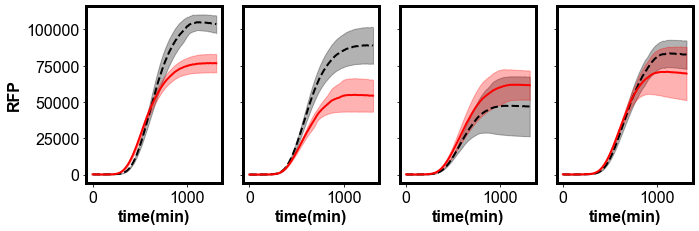

In [530]:
f,ax = plt.subplots(1,4, figsize = (10,3.5), sharey = True)
for i,l in enumerate(['','HB_','HL_','LL_']):
    m0 = RFPEx[exps[l+'c5_0']].mean(1) - RFPEx[exps['blank']].mean(1)
    s0 = (RFPEx[exps[l+'c5_0']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5

    m1 = RFPEx[exps[l+'c5_1']].mean(1) - RFPEx[exps['blank']].mean(1)
    s1 = (RFPEx[exps[l+'c5_1']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5
    
    ax[i].plot(range(0,(len(RFPEx))*10,10), m0, 'k--')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m0-s0,m0+s0, alpha = 0.3, color = 'k')
    
    ax[i].plot(range(0,(len(RFPEx))*10,10), m1, 'r-')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m1-s1,m1+s1, alpha = 0.3, color = 'r')

    fc = (m1/m0).iloc[-1]
    fce = fc*(((s1/m1)**2+(s0/m0)**2)**0.5).iloc[-1]
    
   # ax[i].text(10,13000,'FC: ' + str(round(fc))+'+/-'+str(round(fce)))
    ax[i].set_xlabel("time(min)")    

ax[0].set_ylabel("RFP")
ax[0].set_xlabel("time(min)")    

plt.tight_layout()

In [5]:
path = 'activatable promoters/txtl/big_circuits/'

file = path+'220630_CRISPRa_cascades.csv' # CSV file with raw data (open .txt in Excel, save as .csv)

layout = path+'220630_CRISPRa_cascades_PL.csv' # CSV file with plate layout

plate = pd.read_csv(layout, index_col = 0, dtype = str) # reads plate layout

# need to specify which rows to read for each measurment
columns = pd.read_csv(file, skiprows = 76, nrows = 1,na_values = 'OVRFLW', encoding = "ISO-8859-1").columns
RFPEx= pd.read_csv(file, skiprows = 76, nrows = 132,na_values = 'OVRFLW', encoding = "ISO-8859-1") # reads raw data file at specified rows

RFPEx.columns = columns


In [6]:
# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append(i[0] + i[1])
            
exps # print dictionary to check 

{'c0_0': ['A1', 'B1', 'C1'],
 'c1_0': ['A2', 'B2', 'C2'],
 'c2_0': ['A3', 'B3', 'C3'],
 'c3_0': ['A4', 'B4', 'C4'],
 'c4_0': ['A5', 'B5', 'C5'],
 '3': ['A6', 'B6', 'C6'],
 'd4_0': ['A7', 'A8', 'A9'],
 'd4_1': ['B7', 'B8', 'B9'],
 'e5_0': ['B10', 'B11', 'B12'],
 'e4_0': ['C7', 'C8', 'C9'],
 'e5_1': ['C10', 'C11', 'C12'],
 '4': ['D6', 'E6', 'F6', 'G6'],
 'e4_1': ['D7', 'D8', 'D9'],
 'f5_0': ['D10', 'D11', 'D12', 'G10', 'G12'],
 'c0_1': ['E1', 'F1', 'G1'],
 'c1_1': ['E2', 'F2', 'G2'],
 'c2_1': ['E3', 'F3', 'G3'],
 'c3_1': ['E4', 'F4', 'G4'],
 'c4_1': ['E5', 'F5', 'G5'],
 'f4_0': ['E7', 'E8', 'E9'],
 'f5_1': ['E10', 'E11', 'E12', 'G11'],
 'f4_1': ['F7', 'F8', 'F9'],
 'blank': ['F10', 'F11', 'F12'],
 'g4_0': ['G7', 'G8', 'G9'],
 '1': ['H1', 'H2', 'H3'],
 '2': ['H4', 'H5', 'H6'],
 'g4_1': ['H7', 'H8', 'H9']}

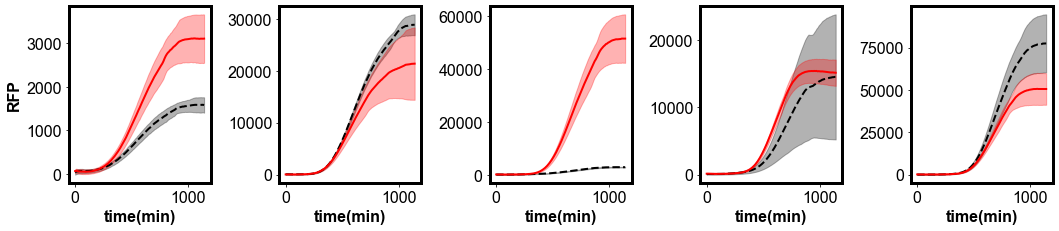

In [12]:
f,ax = plt.subplots(1,5, figsize = (15,3.5), sharey = False)
for i in range(5):
    i = str(i)
    m0 = RFPEx[exps['c'+i+'_0']].mean(1) - RFPEx[exps['blank']].mean(1)
    s0 = (RFPEx[exps['c'+i+'_0']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5
    
    m1 = RFPEx[exps['c'+i+'_1']].mean(1) - RFPEx[exps['blank']].mean(1)
    s1 = (RFPEx[exps['c'+i+'_1']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5

    i = int(i)
    ax[i].plot(range(0,(len(RFPEx))*10,10), m0, 'k--')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m0-s0,m0+s0, alpha = 0.3, color = 'k')
    
    ax[i].plot(range(0,(len(RFPEx))*10,10), m1, 'r-')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m1-s1,m1+s1, alpha = 0.3, color = 'r')

    fc = (m1/m0).iloc[-1]
    fce = fc*(((s1/m1)**2+(s0/m0)**2)**0.5).iloc[-1]
    
    #ax[i].text(10,50000,'FC: ' + str(round(fc))+'+/-'+str(round(fce)))
    ax[i].set_xlabel("time(min)")    

ax[0].set_ylabel("RFP")
ax[0].set_xlabel("time(min)")    

plt.tight_layout()

2.4140926640926637
5.297619047619062


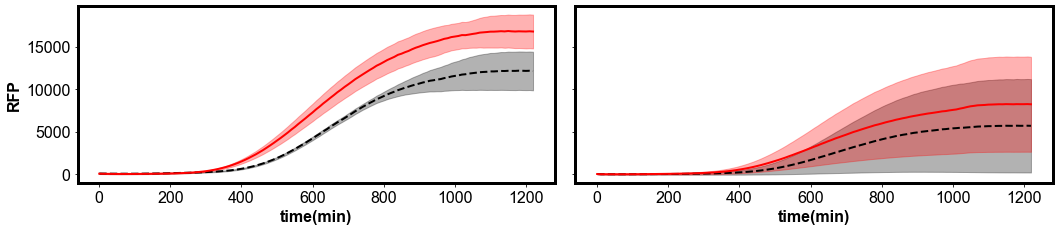

In [56]:
f,ax = plt.subplots(1,2, figsize = (15,3.5), sharey = True)
for i,l in enumerate(['e','f']):
    m0 = RFPEx[exps[l+'5_0']].mean(1) - RFPEx[exps['blank']].mean(1)
    s0 = (RFPEx[exps[l+'5_0']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5
    
    m1 = RFPEx[exps[l+'5_1']].mean(1) - RFPEx[exps['blank']].mean(1)
    s1 = (RFPEx[exps[l+'5_1']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5
    
    print((m1/m0).max())

    ax[i].plot(range(0,(len(RFPEx))*10,10), m0, 'k--')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m0-s0,m0+s0, alpha = 0.3, color = 'k')
    
    ax[i].plot(range(0,(len(RFPEx))*10,10), m1, 'r-')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m1-s1,m1+s1, alpha = 0.3, color = 'r')

    fc = (m1/m0).iloc[-1]
    fce = fc*(((s1/m1)**2+(s0/m0)**2)**0.5).iloc[-1]
    
    #ax[i].text(10,50000,'FC: ' + str(round(fc))+'+/-'+str(round(fce)))
    ax[i].set_xlabel("time(min)")    

ax[0].set_ylabel("RFP")
ax[0].set_xlabel("time(min)")    

plt.tight_layout()

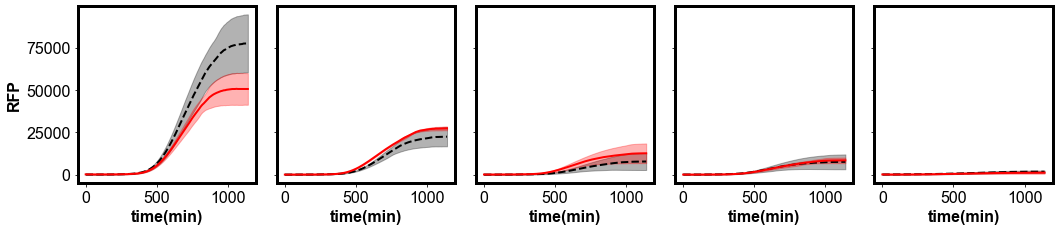

In [11]:
f,ax = plt.subplots(1,5, figsize = (15,3.5), sharey = True)
for i,l in enumerate(['c','d','e','f','g']):
    m0 = RFPEx[exps[l+'4_0']].mean(1) - RFPEx[exps['blank']].mean(1)
    s0 = (RFPEx[exps[l+'4_0']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5
    
    m1 = RFPEx[exps[l+'4_1']].mean(1) - RFPEx[exps['blank']].mean(1)
    s1 = (RFPEx[exps[l+'4_1']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5

    ax[i].plot(range(0,(len(RFPEx))*10,10), m0, 'k--')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m0-s0,m0+s0, alpha = 0.3, color = 'k')
    
    ax[i].plot(range(0,(len(RFPEx))*10,10), m1, 'r-')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m1-s1,m1+s1, alpha = 0.3, color = 'r')

    fc = (m1/m0).iloc[-1]
    fce = fc*(((s1/m1)**2+(s0/m0)**2)**0.5).iloc[-1]
    
    #ax[i].text(10,50000,'FC: ' + str(round(fc))+'+/-'+str(round(fce)))
    ax[i].set_xlabel("time(min)")    

ax[0].set_ylabel("RFP")
ax[0].set_xlabel("time(min)")    

plt.tight_layout()

In [7]:
path = 'activatable promoters/txtl/big_circuits/'

file = path+'220706_CRISPRa_cascades.csv' # CSV file with raw data (open .txt in Excel, save as .csv)

layout = path+'220630_CRISPRa_cascades_PL.csv' # CSV file with plate layout

plate = pd.read_csv(layout, index_col = 0, dtype = str) # reads plate layout

# need to specify which rows to read for each measurment
columns = pd.read_csv(file, skiprows = 76, nrows = 1,na_values = 'OVRFLW', encoding = "ISO-8859-1").columns
RFPEx= pd.read_csv(file, skiprows = 76, nrows = 123,na_values = 'OVRFLW', encoding = "ISO-8859-1") # reads raw data file at specified rows

RFPEx.columns = columns


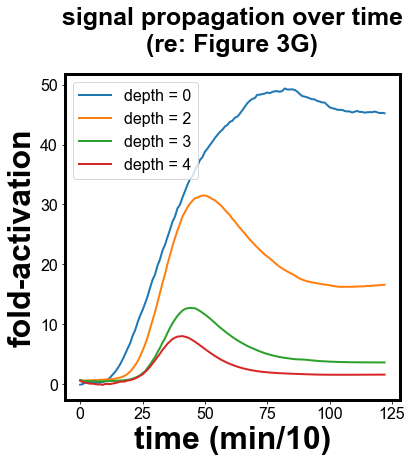

In [51]:
plt.figure(figsize = (6,6))
for i in [0,2,3,4]: 
    test0 = RFPEx[exps['c'+str(i)+'_0']].mean(1) - RFPEx[exps['blank']].mean(1)
    test1 = RFPEx[exps['c'+str(i)+'_1']].mean(1) - RFPEx[exps['blank']].mean(1)
    (test1/test0).plot(label = 'depth = '+str(i))

plt.title('signal propagation over time\n(re: Figure 3G)', pad = 1.5*xpad)
plt.ylabel('fold-activation', size = 32)
plt.xlabel('time (min/10)', size = 32)
plt.legend()

In [52]:
exps

{'c0_0': ['A1', 'B1', 'C1'],
 'c1_0': ['A2', 'B2', 'C2'],
 'c2_0': ['A3', 'B3', 'C3'],
 'c3_0': ['A4', 'B4', 'C4'],
 'c4_0': ['A5', 'B5', 'C5'],
 '3': ['A6', 'B6', 'C6'],
 'd4_0': ['A7', 'A8', 'A9'],
 'd4_1': ['B7', 'B8', 'B9'],
 'e5_0': ['B10', 'B11', 'B12'],
 'e4_0': ['C7', 'C8', 'C9'],
 'e5_1': ['C10', 'C11', 'C12'],
 '4': ['D6', 'E6', 'F6', 'G6'],
 'e4_1': ['D7', 'D8', 'D9'],
 'f5_0': ['D10', 'D11', 'D12', 'G10', 'G12'],
 'c0_1': ['E1', 'F1', 'G1'],
 'c1_1': ['E2', 'F2', 'G2'],
 'c2_1': ['E3', 'F3', 'G3'],
 'c3_1': ['E4', 'F4', 'G4'],
 'c4_1': ['E5', 'F5', 'G5'],
 'f4_0': ['E7', 'E8', 'E9'],
 'f5_1': ['E10', 'E11', 'E12', 'G11'],
 'f4_1': ['F7', 'F8', 'F9'],
 'blank': ['F10', 'F11', 'F12'],
 'g4_0': ['G7', 'G8', 'G9'],
 '1': ['H1', 'H2', 'H3'],
 '2': ['H4', 'H5', 'H6'],
 'g4_1': ['H7', 'H8', 'H9']}

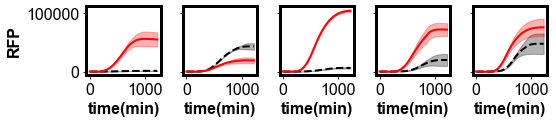

In [58]:
f,ax = plt.subplots(1,5, figsize = (8,2), sharey = True)
allt = []
allte = []
allfc = []
allfce = []
allfc2 = []
allfce2 = []
allt1 = []
allt0 = []
allt1e = []
allt0e = []
for i in range(5):
    m00 = 1#(RFPEx[exps['c0_0']].mean(1) - RFPEx[exps['blank']].mean(1)).iloc[-1]

    i = str(i)
    m0 = RFPEx[exps['c'+i+'_0']].mean(1) - RFPEx[exps['blank']].mean(1)
    s0 = (RFPEx[exps['c'+i+'_0']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5
    
    m1 = RFPEx[exps['c'+i+'_1']].mean(1) - RFPEx[exps['blank']].mean(1)
    s1 = (RFPEx[exps['c'+i+'_1']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5

    i = int(i)
    ax[i].plot(range(0,(len(RFPEx))*10,10), m0/m00, 'k--')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), (m0-s0)/m00,(m0+s0)/m00, alpha = 0.3, color = 'k')
    
    ax[i].plot(range(0,(len(RFPEx))*10,10), m1/m00, 'r-')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), (m1-s1)/m00,(m1+s1)/m00, alpha = 0.3, color = 'r')
    
    fcarg = (m1/m0).argmax()
    fc2 = (m1/m0).iloc[fcarg]
    fce2 = fc2*(((s1/m1)**2+(s0/m0)**2)**0.5).iloc[fcarg]
    
    fc = (m1/m0).iloc[-1]
    fce = fc*(((s1/m1)**2+(s0/m0)**2)**0.5).iloc[-1]
    
    #ax[i].text(10,50000,'FC: ' + str(round(fc))+'+/-'+str(round(fce)))
    ax[i].set_xlabel("time(min)")
    
    
    t10 = (m1-s1).ewm(span=7).mean().diff(3).argmax()
    t11 = (m1+s1).ewm(span=7).mean().diff(3).argmax()
    t1 = (m1).ewm(span=7).mean().diff(3).argmax()
    
    t0 = (m0).ewm(span=7).mean().diff(3).argmax()
    t01 = (m0+s0).ewm(span=7).mean().diff(3).argmax()
    t00 = (m0-s0).ewm(span=7).mean().diff(3).argmax()

    tm1 = np.mean([t10,t11,t1])
    te1 = np.std([t10,t11,t1])
    tm0 = np.mean([t00,t01,t0])
    te0 = np.std([t00,t01,t0])
    
    dt = tm0-tm1
    dte = (te1**2 + te0**2)**0.5
    
    if i == 0:
        allt1.append(tm1*10)
        allt1e.append(te1*10)
        allt0.append(100*10)
        allt0e.append(te0*10)
    else:
        allt1.append(tm1*10)
        allt1e.append(te1*10)
        allt0.append(tm0*10)
        allt0e.append(te0*10)

    if i != 1:
        allt.append(dt*10)
        allte.append(dte*10)
        allfc.append(fc)
        allfce.append(fce)
        allfc2.append(fc2)
        allfce2.append(fce2)
        
    else:
        allt.append(20*10)
        allte.append(1*10)
        allfc.append(33)
        allfce.append(fce)
        allfc2.append(33*1.25)
        allfce2.append(fce2)
    
ax[0].set_ylabel("RFP")
ax[0].set_xlabel("time(min)")    

plt.tight_layout()
plt.savefig('figures/cascades.svg')

In [59]:
allfc.append(1.4)
allfce.append(0.3)
allfc2.append(5.29)
allfce2.append(0.3)
allt.append(45)
allte.append(5)

(0.0, 1000.0)

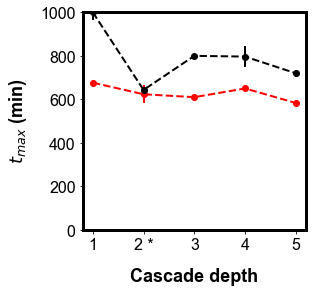

In [768]:
plt.figure(figsize = (4,4))
plt.xlabel('Cascade depth', fontsize = 18, labelpad = xpad)
plt.ylabel('$t_{max}$ (min)',fontsize = 18, labelpad = 1.1*ypad)
plt.xticks(range(7), labels = ['0','1','2 *','3','4','5','6 *'])
plt.errorbar([1,2,3,4,5], allt1,allt1e, fmt = 'ro--')
plt.errorbar([1,2,3,4,5], allt0,allt0e, fmt = 'ko--')
plt.ylim([0,1000])

In [776]:
from scipy import stats

[stats.ttest_ind_from_stats(allt1[-1],allte[-1],3,m2,s2,3, equal_var=False)[1] for m2,s2 in zip(allt1, allt1e)]

[0.0031244399519365805,
 0.23488755021808513,
 0.11293447485451288,
 0.02098700025274365,
 1.0]

C:\Users\Diego Alba\.conda\envs\txtl-sim\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
C:\Users\Diego Alba\.conda\envs\txtl-sim\lib\site-packages\ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


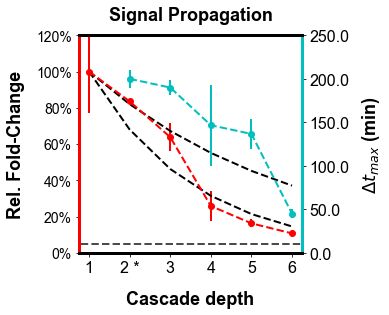

In [90]:
plt.figure(figsize = (4,4))
plt.xlabel('Cascade depth', fontsize = 18, labelpad = xpad)
plt.ylabel('Rel. Fold-Change',fontsize = 18, labelpad = 1.1*ypad)
plt.xticks(range(7), labels = ['0','1','2 *','3','4','5','6'])
plt.errorbar([1,2,3,4,5,6], [0.68**x for x in range(6)], fmt = 'k--')
plt.errorbar([1,2,3,4,5,6], [0.82**x for x in range(6)], fmt = 'k--')

plt.errorbar([1,2,3,4,5,6], np.array(allfc2)/allfc2[0], np.array(allfce2)/allfc2[0], fmt = 'ro--', alpha = 1)
plt.plot([0,7],[0.05, 0.05],'k--', alpha= 0.7)
plt.ylim([0,1.2])
plt.xlim([0.75,6.25])
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()], fontsize = 14)


ax2 = plt.gca().twinx()
plt.errorbar([1,2,3,4,5,6][1:],allt[1:],allte[1:], fmt = 'co--')
plt.ylabel('$\Delta t_{max}$ (min)', fontsize = 18, labelpad = 1.1*ypad)
plt.ylim([0,250])
plt.gca().set_yticklabels(plt.gca().get_yticks(), fontsize = 16)

plt.gca().spines['left'].set_color('red')
plt.gca().spines['right'].set_color('c')

plt.title('Signal Propagation', pad = xpad, fontsize = 18)
plt.savefig('figures/signal_propagation.svg')

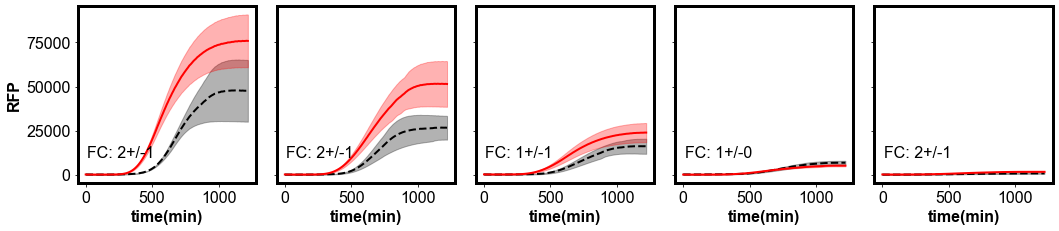

In [610]:
f,ax = plt.subplots(1,5, figsize = (15,3.5), sharey = True)
allt = []
allte = []
for i,l in enumerate(['c','d','e','f','g']):
    m0 = RFPEx[exps[l+'4_0']].mean(1) - RFPEx[exps['blank']].mean(1)
    s0 = (RFPEx[exps[l+'4_0']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5
    
    m1 = RFPEx[exps[l+'4_1']].mean(1) - RFPEx[exps['blank']].mean(1)
    s1 = (RFPEx[exps[l+'4_1']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5

    ax[i].plot(range(0,(len(RFPEx))*10,10), m0, 'k--')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m0-s0,m0+s0, alpha = 0.3, color = 'k')
    
    ax[i].plot(range(0,(len(RFPEx))*10,10), m1, 'r-')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m1-s1,m1+s1, alpha = 0.3, color = 'r')

    fc = (m1/m0).iloc[-1]
    fce = fc*(((s1/m1)**2+(s0/m0)**2)**0.5).iloc[-1]
    
    ax[i].text(10,10000,'FC: ' + str(round(fc))+'+/-'+str(round(fce)))
    ax[i].set_xlabel("time(min)")
    
    t10 = (m1-s1).ewm(span=7).mean().diff(3).argmax()
    t00 = (m0-s0).ewm(span=7).mean().diff(3).argmax()
    
    t11 = (m1+s1).ewm(span=7).mean().diff(3).argmax()
    t01 = (m0+s0).ewm(span=7).mean().diff(3).argmax()
    
    tm1 = np.mean([t10,t11])
    te1 = np.std([t10,t11])
    tm0 = np.mean([t00,t01])
    te0 = np.std([t00,t01])
    
    dt = tm0-tm1
    dte = (te1**2 + te0**2)**0.5

    allt.append(dt*10)
    allte.append(dte*10)

ax[0].set_ylabel("RFP")
ax[0].set_xlabel("time(min)")    

plt.tight_layout()

In [611]:
allt

[135.0, 110.0, 160.0, 95.0, 75.0]

0.30688645430904005
1.7146154404909204


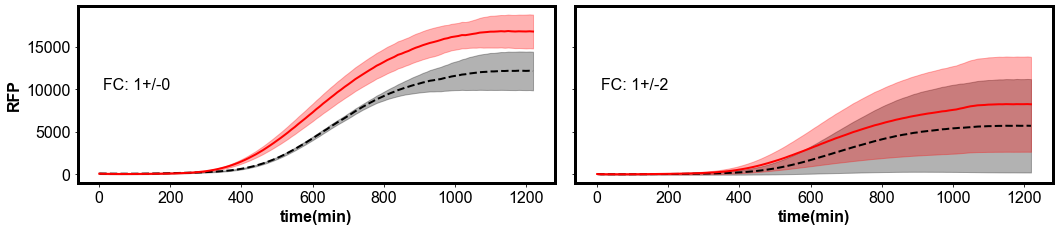

In [660]:
f,ax = plt.subplots(1,2, figsize = (15,3.5), sharey = True)
allt = []
allte = []
for i,l in enumerate(['e','f']):
    m0 = RFPEx[exps[l+'5_0']].mean(1) - RFPEx[exps['blank']].mean(1)
    s0 = (RFPEx[exps[l+'5_0']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5
    
    m1 = RFPEx[exps[l+'5_1']].mean(1) - RFPEx[exps['blank']].mean(1)
    s1 = (RFPEx[exps[l+'5_1']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5

    ax[i].plot(range(0,(len(RFPEx))*10,10), m0, 'k--')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m0-s0,m0+s0, alpha = 0.3, color = 'k')
    
    ax[i].plot(range(0,(len(RFPEx))*10,10), m1, 'r-')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m1-s1,m1+s1, alpha = 0.3, color = 'r')

    fc = (m1/m0).iloc[-1]
    fce = fc*(((s1/m1)**2+(s0/m0)**2)**0.5).iloc[-1]
    
    ax[i].text(10,10000,'FC: ' + str(round(fc))+'+/-'+str(round(fce)))
    ax[i].set_xlabel("time(min)")   
    
    t10 = (m1-s1).ewm(span=7).mean().diff(3).argmax()
    t00 = (m0-s0).ewm(span=7).mean().diff(3).argmax()
    
    t11 = (m1+s1).ewm(span=7).mean().diff(3).argmax()
    t01 = (m0+s0).ewm(span=7).mean().diff(3).argmax()
    
    tm1 = np.mean([t10,t11])
    te1 = np.std([t10,t11])
    tm0 = np.mean([t00,t01])
    te0 = np.std([t00,t01])
    
    dt = tm0-tm1
    dte = (te1**2 + te0**2)**0.5

    allt.append(dt*10)
    allte.append(dte*10)
    
ax[0].set_ylabel("RFP")
ax[0].set_xlabel("time(min)")    

plt.tight_layout()

In [9]:
path = 'activatable promoters/txtl/big_circuits/'

file = path+'220711-CIRSPRa-cascades.csv' # CSV file with raw data (open .txt in Excel, save as .csv)

layout = path+'220711_CRISPRa_cascades_PL.csv' # CSV file with plate layout

plate = pd.read_csv(layout, index_col = 0, dtype = str) # reads plate layout

# need to specify which rows to read for each measurment
columns = pd.read_csv(file, skiprows = 76, nrows = 1,na_values = 'OVRFLW', encoding = "ISO-8859-1").columns
RFPEx= pd.read_csv(file, skiprows = 76, nrows = 123,na_values = 'OVRFLW', encoding = "ISO-8859-1") # reads raw data file at specified rows

RFPEx.columns = columns


In [10]:
# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append(i[0] + i[1])
            
exps # print dictionary to check 

{'blank': ['C1', 'D1', 'E1'],
 'c0_1': ['C2', 'D2', 'E2'],
 'c1_1': ['C3', 'D3', 'E3'],
 'c3_1': ['C4', 'D4', 'E4'],
 'c5_1': ['C5', 'D5', 'E5'],
 'd5_1': ['C6', 'D6', 'E6'],
 'e5_1': ['C7', 'D7', 'E7'],
 '1': ['C9', 'C10', 'C11'],
 '2': ['E9', 'E10', 'E11'],
 'c0_0': ['F2', 'G2', 'H2'],
 'c1_0': ['F3', 'G3', 'H3'],
 'c3_0': ['F4', 'G4', 'H4'],
 'c5_0': ['F5', 'G5', 'H5'],
 'd5_0': ['F6', 'G6', 'H6'],
 'e5_0': ['F7', 'G7', 'H7'],
 '3': ['G9', 'G10', 'G11']}

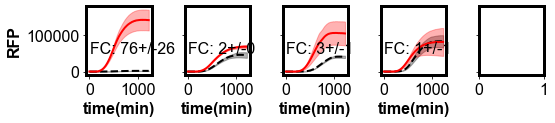

In [13]:
f,ax = plt.subplots(1,5, figsize = (8,2), sharey = True)
allt = []
allte = []
allfc = []
allfce = []
allt1 = []
allt0 = []
allt1e = []
allt0e = []
for k,i in enumerate([0,1,3,5]):
    m00 = 1#(RFPEx[exps['c0_0']].mean(1) - RFPEx[exps['blank']].mean(1)).iloc[-1]

    i = str(i)
    m0 = RFPEx[exps['c'+i+'_0']].mean(1) - RFPEx[exps['blank']].mean(1)
    s0 = (RFPEx[exps['c'+i+'_0']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5
    
    m1 = RFPEx[exps['c'+i+'_1']].mean(1) - RFPEx[exps['blank']].mean(1)
    s1 = (RFPEx[exps['c'+i+'_1']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5

    i = int(i)
    ax[k].plot(range(0,(len(RFPEx))*10,10), m0/m00, 'k--')
    ax[k].fill_between(range(0,(len(RFPEx))*10,10), (m0-s0)/m00,(m0+s0)/m00, alpha = 0.3, color = 'k')
    
    ax[k].plot(range(0,(len(RFPEx))*10,10), m1/m00, 'r-')
    ax[k].fill_between(range(0,(len(RFPEx))*10,10), (m1-s1)/m00,(m1+s1)/m00, alpha = 0.3, color = 'r')

    fc = (m1/m0).iloc[-1]
    fce = fc*(((s1/m1)**2+(s0/m0)**2)**0.5).iloc[-1]
    
    ax[k].text(10,50000,'FC: ' + str(round(fc))+'+/-'+str(round(fce)))
    ax[k].set_xlabel("time(min)")
    
    
    t10 = (m1-s1).ewm(span=7).mean().diff(3).argmax()
    t11 = (m1+s1).ewm(span=7).mean().diff(3).argmax()
    t1 = (m1).ewm(span=7).mean().diff(3).argmax()
    
    t0 = (m0).ewm(span=7).mean().diff(3).argmax()
    t01 = (m0+s0).ewm(span=7).mean().diff(3).argmax()
    t00 = (m0-s0).ewm(span=7).mean().diff(3).argmax()

    tm1 = np.mean([t10,t11,t1])
    te1 = np.std([t10,t11,t1])
    tm0 = np.mean([t00,t01,t0])
    te0 = np.std([t00,t01,t0])
    
    dt = tm0-tm1
    dte = (te1**2 + te0**2)**0.5
    
    if i == 0:
        allt1.append(tm1*10)
        allt1e.append(te1*10)
        allt0.append(100*10)
        allt0e.append(te0*10)
    else:
        allt1.append(tm1*10)
        allt1e.append(te1*10)
        allt0.append(tm0*10)
        allt0e.append(te0*10)

    if i != 1:
        allt.append(dt*10)
        allte.append(dte*10)
        allfc.append(fc)
        allfce.append(fce)
        
    else:
        allt.append(20*10)
        allte.append(1*10)
        allfc.append(33)
        allfce.append(fce)
    
ax[0].set_ylabel("RFP")
ax[0].set_xlabel("time(min)")    

plt.tight_layout()


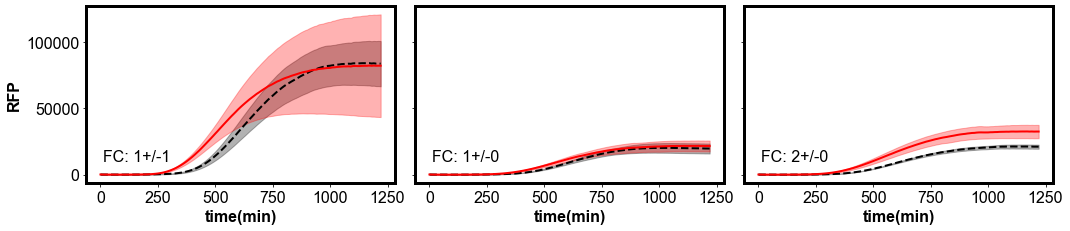

In [14]:
f,ax = plt.subplots(1,3, figsize = (15,3.5), sharey = True)
allt = []
allte = []
for i,l in enumerate(['c','d','e']):
    m0 = RFPEx[exps[l+'5_0']].mean(1) - RFPEx[exps['blank']].mean(1)
    s0 = (RFPEx[exps[l+'5_0']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5
    
    m1 = RFPEx[exps[l+'5_1']].mean(1) - RFPEx[exps['blank']].mean(1)
    s1 = (RFPEx[exps[l+'5_1']].std(1)**2 + RFPEx[exps['blank']].std(1)**2)**0.5

    ax[i].plot(range(0,(len(RFPEx))*10,10), m0, 'k--')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m0-s0,m0+s0, alpha = 0.3, color = 'k')
    
    ax[i].plot(range(0,(len(RFPEx))*10,10), m1, 'r-')
    ax[i].fill_between(range(0,(len(RFPEx))*10,10), m1-s1,m1+s1, alpha = 0.3, color = 'r')

    fc = (m1/m0).iloc[-1]
    fce = fc*(((s1/m1)**2+(s0/m0)**2)**0.5).iloc[-1]
    
    ax[i].text(10,10000,'FC: ' + str(round(fc))+'+/-'+str(round(fce)))
    ax[i].set_xlabel("time(min)")   
    
    t10 = (m1-s1).ewm(span=7).mean().diff(3).argmax()
    t00 = (m0-s0).ewm(span=7).mean().diff(3).argmax()
    
    t11 = (m1+s1).ewm(span=7).mean().diff(3).argmax()
    t01 = (m0+s0).ewm(span=7).mean().diff(3).argmax()
    
    tm1 = np.mean([t10,t11])
    te1 = np.std([t10,t11])
    tm0 = np.mean([t00,t01])
    te0 = np.std([t00,t01])
    
    dt = tm0-tm1
    dte = (te1**2 + te0**2)**0.5

    allt.append(dt*10)
    allte.append(dte*10)
    
ax[0].set_ylabel("RFP")
ax[0].set_xlabel("time(min)")    

plt.tight_layout()